
# <a id='toc1_'></a>[Application and comparison of regression models for forecasting the price development of an underlying asset: An empirical study with COT data](#toc0_)
__Which regression variant in machine learning is best suited to predict the future price development of gold using COT data?__

24.05.2024 Thomas Bernhard
***

**Table of contents**<a id='toc0_'></a>    
- [Data](#toc1_1_)    
  - [Data gathering](#toc1_1_1_)    
  - [COT Report Data](#toc1_1_2_)    
    - [Which should we follow?](#toc1_1_2_1_)    
  - [Federal Reserve Economic Data (FRED)](#toc1_1_3_)    
  - [Data clean up](#toc1_1_4_)    
  - [Data analysis](#toc1_1_5_)    
- [Feature evaluation](#toc1_2_)    
- [Creating a Linear Regression Model](#toc1_3_)    
- [Biased Linear Regression Models](#toc1_4_)    
- [Comparison](#toc1_5_)    
- [Conclusion](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from collections import Counter

In [2]:
now = datetime.now()

# Format the datetime into a string suitable for a file name
# Example: '20220315123045'
timestamp = now.strftime("%Y%m%d%H%M%S")

## <a id='toc1_1_'></a>[Data](#toc0_)
### <a id='toc1_1_1_'></a>[Data gathering](#toc0_)

### <a id='toc1_1_2_'></a>[COT Report Data](#toc0_)

Usage of cot_reports

Available report types with the corresponding 'cot_report_type' name used in the library:
report 	'cot_report_type'
| Report | Description | Parameter |
| :------------ | :------------ | :------------ |
| Legacy Report                      | Futures-only 	                            | 'legacy_fut'                          |
| Legacy Report                      | Futures-and-Options Combined 	            | 'legacy_futopt'                       | 
| Supplemental Report                | Futures-and-Options combined (short format)  | 'supplemental_futopt'                 |  
| Disaggregated Report               | Futures-only 	                            | 'disaggregated_fut'                   | 
| Disaggregated Report               | Futures-and-Options Combined 	            | 'disaggregated_futopt'                | 
| Traders in Financial Futures (TFF) | 	                                            | 'traders_in_financial_futures_fut'    | 
| Traders in Financial Futures (TFF) | Futures-and-Options Combined 	            | 'traders_in_financial_futures_futopt' | 



Disaggregated (disaggregated_fut):
- Lagacy zoomed in
- Commercial: Producers, Merchants, Processors, Users, & Swap Dealers
- Non-commercials: Managed Money & Other Reportable

[Markets Made Clear](https://www.marketsmadeclear.com/Blog/What-is-the-Commitments-of-Traders.aspx)


#### <a id='toc1_1_2_1_'></a>[Which should we follow?](#toc0_)
A longer term investor will be more interested in Commercial positions whereas a short term trader will be interested in the Non-commercial positions.
Let’s start by discussing the Non-commercials. If we consider a market in an uptrend, during this time the non-commercials will be adding new or 
increasing their existing long positions. This makes sense of course; as a market moves up they will always look to buy it and profit from its 
continued price in-crease. This group are known as trend followers and this is the side you will want to be on if you are a short term speculator.

Now let’s discuss the Commercials. This group is vastly different and a little harder to understand but the one thing you must remember is that 
this group does not look to profit from the market. They use it to actually buy and sell the commodities being traded, and take delivery of them,
which speculators will never do. Another way in which they use the market is to hedge against exposure they have from another market they are involved in.
If we consider this group in an uptrend their actions will be very different from the Non-commercials. As a market rises the commercials will be 
selling and they won’t be wrong in doing so because they will actually be selling the product at that price and not simply selling and looking for
the market to fall and profit, the way a speculator would. This action will continue until such times that this group believes it can’t go much 
higher and their selling will reach extreme levels as they try to sell as much of their product before the price falls and a new trend starts in 
the opposite direction. It is for this reason this group are known as trend enders, and this is the group you will want to follow to take long 
term positions in the market.

***Non-commercials - trend followers***

***Commercials     - trend enders***

That means we should focus on Commercials extreme trends

In [3]:
import cot_reports as cot
import pandas as pd
import seaborn as sns

your_data_path = 'D:/OneDrive/OST/MATH/Code/MATH/Data/'

# cot_all() downloads the historical bulk file and all remaining single year files of the specified report type.  
# Returns the data as dataframe.
# Note: The historical bulk file F_Disagg06_16.txt and f_year.txt will be created in the same directory as this ipynb.
cot_report_type = 'disaggregated_fut'
# df = pd.DataFrame(cot.cot_all(cot_report_type=cot_report_type)) TODO uncomment

# We only take into account the "GOLD - COMMODITY EXCHANGE INC."
# dfsubsetgold = df[df["Market_and_Exchange_Names"].isin(["GOLD - COMMODITY EXCHANGE INC."])] TODO uncomment

# Export DataFrame as CSV
# from pathlib import Path TODO uncomment

# filepath = Path(your_data_path+cot_report_type+'_gold.csv') TODO uncomment
# filepath.parent.mkdir(parents=True, exist_ok=True) TODO uncomment
# dfsubsetgold.to_csv(filepath) TODO uncomment

In [4]:
# Load the csv into a data frame
filepath = Path(your_data_path+cot_report_type+'_gold.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
cotgolddata = pd.read_csv(filepath, sep=',')

pd.set_option("display.max.columns", None)
cotgolddata.head()


Unnamed: 0       Market_and_Exchange_Names  As_of_Date_In_Form_YYMMDD  \
0       64439  GOLD - COMMODITY EXCHANGE INC.                     161227   
1       64440  GOLD - COMMODITY EXCHANGE INC.                     161220   
2       64441  GOLD - COMMODITY EXCHANGE INC.                     161213   
3       64442  GOLD - COMMODITY EXCHANGE INC.                     161206   
4       64443  GOLD - COMMODITY EXCHANGE INC.                     161129   

  Report_Date_as_YYYY-MM-DD  CFTC_Contract_Market_Code CFTC_Market_Code  \
0                2016-12-27                      88691             CMX    
1                2016-12-20                      88691             CMX    
2                2016-12-13                      88691             CMX    
3                2016-12-06                      88691             CMX    
4                2016-11-29                      88691             CMX    

   CFTC_Region_Code  CFTC_Commodity_Code  Open_Interest_All  \
0                 1                   88             401513   
1                 1                   88             398661   
2                 1                   88             397034   
3                 1                   88             393524   
4                 1                   88             405661   

   Prod_Merc_Positions_Long_All  Prod_Merc_Positions_Short_All  \
0                         23547                          97994   
1                         22130                         101474   
2                         22199                         103372   
3                         21781                         105209   
4                         24102                         114690   

   Swap_Positions_Long_All  Swap__Positions_Short_All  \
0                    41038                      87558   
1                    39604                      94282   
2                    28815                      97528   
3                    28749                     100265   
4                    25014                     102249   

   Swap__Positions_Spread_All  M_Money_Positions_Long_All  \
0                       25390                      130595   
1                       26226                      137588   
2                       35129                      146150   
3                       35707                      150856   
4                       43512                      162086   

   M_Money_Positions_Short_All  M_Money_Positions_Spread_All  \
0                        87229                         31876   
1                        83783                         21490   
2                        77432                         14367   
3                        68538                         13357   
4                        55145                         14452   

   Other_Rept_Positions_Long_All  Other_Rept_Positions_Short_All  \
0                          75943                           20966   
1                          81479                           20450   
2                          83605                           23012   
3                          76819                           22757   
4                          67645                           23016   

   Other_Rept_Positions_Spread_All  Tot_Rept_Positions_Long_All  \
0                            23960                       352349   
1                            22852                       351369   
2                            20677                       350942   
3                            20616                       347885   
4                            23283                       360094   

   Tot_Rept_Positions_Short_All  NonRept_Positions_Long_All  \
0                        374973                       49164   
1                        370557                       47292   
2                        371517                       46092   
3                        366449                       45639   
4                        376347                       45567   

   NonRept_Positions_Short_All  O

### <a id='toc1_1_3_'></a>[Federal Reserve Economic Data (FRED)](#toc0_)
Access to a wide range of economic data provided by the Federal Reserve Bank of St. Louis. 
We are going to focus on the Global Economic Policy Uncertainty Index: Current Price Adjusted GDP (GEPUCURRENT)

https://fred.stlouisfed.org/

In [5]:
# import pandas_datareader.data as web
# from datetime import datetime

# Define the start date and the end date
# start_date = datetime(2006, 1, 1)
# end_date = datetime.now()

# Lade die Daten von FRED
# symbol = 'GEPUCURRENT'
# df = web.DataReader(symbol, 'fred', start_date, end_date)

The code above did not work so we gathered the data manually via csv download.

https://fred.stlouisfed.org/series/GEPUCURRENT

In [6]:
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override() # <== that's all it takes :-)

# GOLD - COMMODITY EXCHANGE INC. (GC=F)
# Crude Oil Jun 24 (CL=F)
# US Dollar Index (DX-Y.NYB)

# Download dataframes
# dataGold = pdr.get_data_yahoo("GC=F", start="2006-06-01", end="2024-05-01")    TODO uncomment
# dataOil = pdr.get_data_yahoo("CL=F", start="2006-06-01", end="2024-05-01")     TODO uncomment
# dataUSD = pdr.get_data_yahoo("DX-Y.NYB", start="2006-06-01", end="2024-05-01") TODO uncomment

# TODO uncomment
# filepath = Path(your_data_path+'price_file_gold.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# dataGold.to_csv(filepath)
# TODO uncomment
# filepath = Path(your_data_path+'price_file_oil.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# dataOil.to_csv(filepath)
# TODO uncomment
# filepath = Path(your_data_path+'price_file_usd.csv')
# filepath.parent.mkdir(parents=True, exist_ok=True)
# dataUSD.to_csv(filepath)


filepath = Path(your_data_path+'price_file_gold.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
goldPriceData = pd.read_csv(filepath, sep=',')

filepath = Path(your_data_path+'price_file_oil.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
oilPriceData = pd.read_csv(filepath, sep=',')

filepath = Path(your_data_path+'price_file_usd.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
usdPriceData = pd.read_csv(filepath, sep=',')


# Retrieval of data on the Global Economic Policy Uncertainty Index: Current price-adjusted GDP from FRED
# https://fred.stlouisfed.org/series/GEPUCURRENT

filepath = Path(your_data_path+'GEPUCURRENT.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
gepucurrentData = pd.read_csv(filepath, sep=',')

In [7]:
print(goldPriceData.sample(3))

            Date         Open         High          Low        Close  \
4190  2023-01-27  1928.599976  1928.599976  1928.599976  1928.599976   
2171  2015-01-15  1231.500000  1265.000000  1227.300049  1264.699951   
3017  2018-05-31  1301.000000  1306.800049  1296.599976  1300.099976   

        Adj Close  Volume  
4190  1928.599976  150902  
2171  1264.699951     130  
3017  1300.099976    4082  


In [8]:
goldPriceData.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
gepucurrentData.head()

DATE  GEPUCURRENT
0  01/01/2006    68.718279
1  01/02/2006    58.188138
2  01/03/2006    58.341684
3  01/04/2006    72.915166
4  01/05/2006    63.126311

### <a id='toc1_1_4_'></a>[Data clean up](#toc0_)
*Format and group columns, to begin analysis of the data*

In [10]:
def convert_dates(column, fromformat, toformat):
    
    """ convert the df's date column into a datetime format 
            for sorting and concatentation purposes"""
    
    column = column.apply(lambda x: pd.to_datetime(x, format=fromformat).strftime(toformat))
    column = pd.to_datetime(column, format=toformat)
    return column

cotgolddata['Report_Date_as_YYYY-MM-DD'] = convert_dates(cotgolddata['Report_Date_as_YYYY-MM-DD'],'%Y-%m-%d','%d.%m.%Y')  
goldPriceData['Date'] = convert_dates(goldPriceData['Date'],'%Y-%m-%d','%d.%m.%Y')
usdPriceData['Date'] = convert_dates(usdPriceData['Date'],'%Y-%m-%d','%d.%m.%Y')
oilPriceData['Date'] = convert_dates(oilPriceData['Date'],'%Y-%m-%d','%d.%m.%Y')
gepucurrentData['DATE'] = convert_dates(gepucurrentData['DATE'],'%d/%m/%Y','%d.%m.%Y')
# Output will be formated like YYYY-MM-DD: This format ("YYYY-MM-DD") is the default string representation of a datetime object in Pandas and Python.

In [11]:
goldPriceData.first
# goldPriceData.dtypes

<bound method NDFrame.first of            Date         Open         High          Low        Close  \
0    2006-06-01   642.799988   645.099976   620.000000   627.599976   
1    2006-06-02   628.000000   637.500000   622.599976   635.500000   
2    2006-06-05   635.500000   645.000000   635.500000   643.200012   
3    2006-06-06   643.400024   643.400024   625.000000   629.400024   
4    2006-06-07   629.200012   629.799988   617.500000   627.400024   
...         ...          ...          ...          ...          ...   
4502 2024-04-24  2321.300049  2328.699951  2314.600098  2324.500000   
4503 2024-04-25  2315.000000  2329.800049  2305.000000  2329.800049   
4504 2024-04-26  2347.899902  2347.899902  2332.800049  2334.800049   
4505 2024-04-29  2334.800049  2345.500000  2327.899902  2345.399902   
4506 2024-04-30  2322.500000  2322.500000  2291.399902  2291.399902   

        Adj Close  Volume  
0      627.599976    1682  
1      635.500000    1151  
2      643.200012     613  
3   

In [12]:
# Sort dfs by date for chronological purposes
goldPriceData = goldPriceData.sort_values(by='Date').reset_index(drop=True)
usdPriceData = usdPriceData.sort_values(by='Date').reset_index(drop=True)
oilPriceData = oilPriceData.sort_values(by='Date').reset_index(drop=True)
gepucurrentData = gepucurrentData.sort_values(by='DATE').reset_index(drop=True)
cotgolddata = cotgolddata.sort_values(by='Report_Date_as_YYYY-MM-DD').reset_index(drop=True)

# Rename to 'Date' for concatenation
cotgolddata.rename(columns = {'Report_Date_as_YYYY-MM-DD':'Date'}, inplace = True)
cotgolddata = cotgolddata.sort_values(by='Date').reset_index(drop=True)

# Rename to corresponding Price for concatenation
goldPriceData.rename(columns = {'Close':'Price'}, inplace = True)
usdPriceData.rename(columns = {'Close':'USDPrice'}, inplace = True)
oilPriceData.rename(columns = {'Close':'OilPrice'}, inplace = True)
gepucurrentData.rename(columns = {'DATE':'Date'}, inplace = True)

In [13]:
# Delete rows - they add no further information
# List of columns to drop
cols_to_drop = ['Open','High','Low','Adj Close', 'Volume']

# Drop the columns
goldPriceData.drop(cols_to_drop, axis=1, inplace=True)
usdPriceData.drop(cols_to_drop, axis=1, inplace=True)
oilPriceData.drop(cols_to_drop, axis=1, inplace=True)

In [14]:
goldPriceData

Date        Price
0    2006-06-01   627.599976
1    2006-06-02   635.500000
2    2006-06-05   643.200012
3    2006-06-06   629.400024
4    2006-06-07   627.400024
...         ...          ...
4502 2024-04-24  2324.500000
4503 2024-04-25  2329.800049
4504 2024-04-26  2334.800049
4505 2024-04-29  2345.399902
4506 2024-04-30  2291.399902

[4507 rows x 2 columns]

In [15]:
# Dates of COT reports are on Firday (with data backdated from Thuesday), for each commencing week 
# Price data is Monday to Monday
# I must therefore increase the price data, date, to Friday to concat dfs 
# and match the week prices with cot reports

goldPriceDataFF = goldPriceData.copy()
goldPriceDataFF['Date'] = goldPriceDataFF['Date'] - timedelta(days=3)

usdPriceDataFF = usdPriceData.copy()
usdPriceDataFF['Date'] = usdPriceDataFF['Date'] - timedelta(days=3)

oilPriceDataFF = oilPriceData.copy()
oilPriceDataFF['Date'] = oilPriceDataFF['Date'] - timedelta(days=3)

In [16]:
# Rename to corresponding Price for concatenation
goldPriceDataFF.rename(columns = {'Price':'WeeklyFridayPrice'}, inplace = True)
usdPriceDataFF.rename(columns = {'USDPrice':'WeeklyFridayUSDPrice'}, inplace = True)
oilPriceDataFF.rename(columns = {'OilPrice':'WeeklyFridayOilPrice'}, inplace = True)

In [17]:
goldPriceDataFF

Date  WeeklyFridayPrice
0    2006-05-29         627.599976
1    2006-05-30         635.500000
2    2006-06-02         643.200012
3    2006-06-03         629.400024
4    2006-06-04         627.400024
...         ...                ...
4502 2024-04-21        2324.500000
4503 2024-04-22        2329.800049
4504 2024-04-23        2334.800049
4505 2024-04-26        2345.399902
4506 2024-04-27        2291.399902

[4507 rows x 2 columns]

In [18]:
# Merge dfs on date
df_cot_price = cotgolddata.merge(goldPriceData, how='left', on='Date')
df_cot_price = df_cot_price.merge(goldPriceDataFF, how='left', on='Date')
df_cot_price = df_cot_price.merge(usdPriceData, how='left', on='Date')
df_cot_price = df_cot_price.merge(usdPriceDataFF, how='left', on='Date')
df_cot_price = df_cot_price.merge(oilPriceData, how='left', on='Date')
df_cot_price = df_cot_price.merge(oilPriceDataFF, how='left', on='Date')

# Merge the dfs, whereby the monthly data is filled forwards
df_cot_price = pd.merge_asof(df_cot_price.sort_values('Date'), gepucurrentData.sort_values('Date'), on='Date', direction='backward')

df_cot_price

Unnamed: 0       Market_and_Exchange_Names  As_of_Date_In_Form_YYMMDD  \
0         64989  GOLD - COMMODITY EXCHANGE INC.                      60613   
1         64988  GOLD - COMMODITY EXCHANGE INC.                      60620   
2         64987  GOLD - COMMODITY EXCHANGE INC.                      60627   
3         64986  GOLD - COMMODITY EXCHANGE INC.                      60703   
4         64985  GOLD - COMMODITY EXCHANGE INC.                      60711   
..          ...                             ...                        ...   
931        4734  GOLD - COMMODITY EXCHANGE INC.                     240416   
932        4733  GOLD - COMMODITY EXCHANGE INC.                     240423   
933        4732  GOLD - COMMODITY EXCHANGE INC.                     240430   
934        4731  GOLD - COMMODITY EXCHANGE INC.                     240507   
935        4730  GOLD - COMMODITY EXCHANGE INC.                     240514   

          Date  CFTC_Contract_Market_Code CFTC_Market_Code  CFTC_Region_Code  \
0   2006-06-13                      88691              CMX                 1   
1   2006-06-20                      88691              CMX                 1   
2   2006-06-27                      88691              CMX                 1   
3   2006-07-03                      88691              CMX                 1   
4   2006-07-11                      88691              CMX                 1   
..         ...                        ...              ...               ...   
931 2024-04-16                      88691             CMX                  1   
932 2024-04-23                      88691             CMX                  1   
933 2024-04-30                      88691             CMX                  1   
934 2024-05-07                      88691             CMX                  1   
935 2024-05-14                      88691             CMX                  1   

     CFTC_Commodity_Code  Open_Interest_All  Prod_Merc_Positions_Long_All  \
0                     88             288981                         27041   
1                     88             288148                         29230   
2                     88             292789                         30747   
3                     88             292500                         29615   
4                     88             312684                         34094   
..                   ...                ...                           ...   
931                   88             517193                         37797   
932                   88             516249                         37917   
933                   88             519791                         37917   
934                   88             529835                         35488   
935                   88             522952                         35446   

     Prod_Merc_Positions_Short_All  Swap_Positions_Long_All  \
0                           117483                    19940   
1                           112900                    23091   
2                           110141                    23112   
3                           108909                    23735   
4                           114612                    23173   
..                             ...                      ...   
931                          71700                    78012   
932                          70510                    75873   
933                          68644                    73085   
934                          67658                    73131   
935                          65005                    75210   

     Swap__Positions_Short_All  Swap__Positions_Spread_All  \
0                        63899                        4718   
1                        61692                        6492   
2                        59959                        7236   
3                        66608                        6752   
4                        74702                        7141   
..                         ...                       

In [19]:
# CSV Export
filepath = Path(your_data_path+timestamp+'_gold_cot_price_report.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_cot_price.to_csv(filepath)

**More Data Preperation**

*Calculating additional columns in our dataframe to help aid our analysis*

In [20]:
# Shift the column of 'Price' up a row, this will show you the price increase/
# decrease for the following week, post the release of the COT report.
# I.e the Change in Price
df_cot_price['Post Week Price'] = df_cot_price['Price'].shift(-1)
df_cot_price['Change to Post Week Price ABS'] = df_cot_price['Post Week Price'] - df_cot_price['Price'] # Trading Week Price Absolute Difference
df_cot_price['Change to Post Week Price %'] = (df_cot_price['Post Week Price'] - df_cot_price['Price'])/df_cot_price['Price'] * 100 # Trading Week Price Performance
df_cot_price['Change to Friday Price ABS'] = df_cot_price['WeeklyFridayPrice'] - df_cot_price['Price']
df_cot_price['Change to Friday Price %'] = (df_cot_price['WeeklyFridayPrice'] - df_cot_price['Price'])/df_cot_price['Price'] * 100
df_cot_price['Post Week Friday Price'] = df_cot_price['WeeklyFridayPrice'].shift(-1)
df_cot_price['WeeklyFridayPrice change to Post Week Friday Price ABS'] = df_cot_price['Post Week Friday Price'] - df_cot_price['WeeklyFridayPrice']
df_cot_price['WeeklyFridayPrice change to Post Week Friday Price %'] = (df_cot_price['Post Week Friday Price'] - df_cot_price['WeeklyFridayPrice'])/df_cot_price['WeeklyFridayPrice'] * 100

df_cot_price['Post Week Friday USDPrice'] = df_cot_price['WeeklyFridayUSDPrice'].shift(-1)

In [21]:
df_cot_price

Unnamed: 0       Market_and_Exchange_Names  As_of_Date_In_Form_YYMMDD  \
0         64989  GOLD - COMMODITY EXCHANGE INC.                      60613   
1         64988  GOLD - COMMODITY EXCHANGE INC.                      60620   
2         64987  GOLD - COMMODITY EXCHANGE INC.                      60627   
3         64986  GOLD - COMMODITY EXCHANGE INC.                      60703   
4         64985  GOLD - COMMODITY EXCHANGE INC.                      60711   
..          ...                             ...                        ...   
931        4734  GOLD - COMMODITY EXCHANGE INC.                     240416   
932        4733  GOLD - COMMODITY EXCHANGE INC.                     240423   
933        4732  GOLD - COMMODITY EXCHANGE INC.                     240430   
934        4731  GOLD - COMMODITY EXCHANGE INC.                     240507   
935        4730  GOLD - COMMODITY EXCHANGE INC.                     240514   

          Date  CFTC_Contract_Market_Code CFTC_Market_Code  CFTC_Region_Code  \
0   2006-06-13                      88691              CMX                 1   
1   2006-06-20                      88691              CMX                 1   
2   2006-06-27                      88691              CMX                 1   
3   2006-07-03                      88691              CMX                 1   
4   2006-07-11                      88691              CMX                 1   
..         ...                        ...              ...               ...   
931 2024-04-16                      88691             CMX                  1   
932 2024-04-23                      88691             CMX                  1   
933 2024-04-30                      88691             CMX                  1   
934 2024-05-07                      88691             CMX                  1   
935 2024-05-14                      88691             CMX                  1   

     CFTC_Commodity_Code  Open_Interest_All  Prod_Merc_Positions_Long_All  \
0                     88             288981                         27041   
1                     88             288148                         29230   
2                     88             292789                         30747   
3                     88             292500                         29615   
4                     88             312684                         34094   
..                   ...                ...                           ...   
931                   88             517193                         37797   
932                   88             516249                         37917   
933                   88             519791                         37917   
934                   88             529835                         35488   
935                   88             522952                         35446   

     Prod_Merc_Positions_Short_All  Swap_Positions_Long_All  \
0                           117483                    19940   
1                           112900                    23091   
2                           110141                    23112   
3                           108909                    23735   
4                           114612                    23173   
..                             ...                      ...   
931                          71700                    78012   
932                          70510                    75873   
933                          68644                    73085   
934                          67658                    73131   
935                          65005                    75210   

     Swap__Positions_Short_All  Swap__Positions_Spread_All  \
0                        63899                        4718   
1                        61692                        6492   
2                        59959                        7236   
3                        66608                        6752   
4                        74702                        7141   
..                         ...                       

In [22]:
# Remove all change values that are NaN
# Removing is best practive as statistical fill would produce innacurate results
df_cot_price = df_cot_price.dropna()

In [23]:
# Delete all rows ending with "_OLD" - they add no further information
# List of columns to drop
cols_to_drop = [col for col in df_cot_price.columns if col.upper().endswith('_OLD')]

# Drop the columns
df_cot_price.drop(cols_to_drop, axis=1, inplace=True)

C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\1857570210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price.drop(cols_to_drop, axis=1, inplace=True)


In [24]:
# Delete all rows ending with "_OTHER" - they add no further information
# List of columns to drop
cols_to_drop = [col for col in df_cot_price.columns if col.upper().endswith('_OTHER')]
# Drop the columns
df_cot_price.drop(cols_to_drop, axis=1, inplace=True)

C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\1292489252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price.drop(cols_to_drop, axis=1, inplace=True)


In [25]:
# CSV Export
filepath = Path(your_data_path+timestamp+'_gold_cot_price_report_short.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_cot_price.to_csv(filepath)

*Create additional columns of potential interest for analysis*

In [26]:
def amount_net_position_abs_ind(column1, column2, status='industry'):
    
    """Calculate the weekly net position absolute terms for each
        industry/institiuon
        Net Position ABS > 0 : Net Long
        Net Position ABS < 0 : Net Short"""
    
    
    df_cot_price[f'{status} Net Position ABS'] = column1 - column2

# Commercials
amount_net_position_abs_ind(df_cot_price['Prod_Merc_Positions_Long_All'], 
                            df_cot_price['Prod_Merc_Positions_Short_All'],
                            status='Merc')

amount_net_position_abs_ind(df_cot_price['Swap_Positions_Long_All'],
                            df_cot_price['Swap__Positions_Short_All'],
                            status='Swap')
# Non-Commercials
amount_net_position_abs_ind(df_cot_price['M_Money_Positions_Long_All'], 
                            df_cot_price['M_Money_Positions_Short_All'],
                            status='Managed')

amount_net_position_abs_ind(df_cot_price['Other_Rept_Positions_Long_All'],
                            df_cot_price['Other_Rept_Positions_Short_All'],
                            status='Other')

C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\3878943710.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Net Position ABS'] = column1 - column2
C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\3878943710.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Net Position ABS'] = column1 - column2
C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\3878943710.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [27]:
def amount_traders_abs_ind(column1, column2, status='industry'):
    
    """Calculate the weekly Traders absolute terms for each
        industry/institiuon
        Traders ABS > 0 : Net Long
        Traders ABS < 0 : Net Short"""
    
    
    df_cot_price[f'{status} Traders ABS'] = column1 - column2

# Commercials
amount_traders_abs_ind(df_cot_price['Traders_Prod_Merc_Long_All'], 
                       df_cot_price['Traders_Prod_Merc_Short_All'], 
                       status='Merc')

amount_traders_abs_ind(df_cot_price['Traders_Swap_Long_All'],
                       df_cot_price['Traders_Swap_Short_All'],
                       status='Swap')
# Non-Commercials
amount_traders_abs_ind(df_cot_price['Traders_M_Money_Long_All'], 
                       df_cot_price['Traders_M_Money_Short_All'],
                       status='Managed')

amount_traders_abs_ind(df_cot_price['Traders_Other_Rept_Long_All'],
                       df_cot_price['Traders_Other_Rept_Short_All'], 
                       status='Other')

C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\750210236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Traders ABS'] = column1 - column2
C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\750210236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Traders ABS'] = column1 - column2
C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\750210236.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [28]:
def amount_net_position_abs_cat(column1, column2, status='category'):
    
    """Calculate the weekly net position absolute terms for each
        industry/institiuon
        Net Position ABS > 0 : Net Long
        Net Position ABS < 0 : Net Short"""
    
    
    df_cot_price[f'{status} Net Position ABS'] = column1 + column2
    
# Commercials
amount_net_position_abs_cat(df_cot_price['Merc Net Position ABS'], 
                            df_cot_price['Swap Net Position ABS'], 
                            status='Commercials')

amount_net_position_abs_cat(df_cot_price['Managed Net Position ABS'], 
                            df_cot_price['Other Net Position ABS'], 
                            status='NonCommercials')

C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\1095806461.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Net Position ABS'] = column1 + column2
C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\1095806461.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Net Position ABS'] = column1 + column2


In [29]:
def amount_traders_abs_cat(column1, column2, status='category'):
    
    """Calculate the weekly traders absolute terms for each
        industry/institiuon
        Traders ABS > 0 : Net Long
        Traders ABS < 0 : Net Short"""
    
    
    df_cot_price[f'{status} Traders ABS'] = column1 + column2
    
# Commercials
amount_traders_abs_cat(df_cot_price['Merc Traders ABS'], 
                       df_cot_price['Swap Traders ABS'], 
                       status='Commercials')

amount_traders_abs_cat(df_cot_price['Managed Traders ABS'], 
                       df_cot_price['Other Traders ABS'], 
                       status='NonCommercials')

C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\1538301539.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Traders ABS'] = column1 + column2
C:\Users\tbern\AppData\Local\Temp\ipykernel_14600\1538301539.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cot_price[f'{status} Traders ABS'] = column1 + column2


In [30]:
import math

df_cot_price = df_cot_price.reset_index(drop=True)

# Exclusion of inter trading weekly net long/short changes
# If the net position is directionally the same (long or short) 
# at the start and end of the trading week, it is assumed that the 
# position remained directionally the same throughout the week. 
# If the net position is directionally different at the end of the trading week from the start of the 
# week, that week is ignored from the evaluation as there is no way of knowing when the posi￾tion changed. 
# Page 49 - Keenan, M. J. S. (2020). Advanced positioning, flow, and sentiment analysis in commodity markets: : Bridging fundamental and technical analysis (Second edition.). Wiley.

def net_position_directionally_different(column1, status='industry'):
    
    """Calculate whether the net position for each
       industry/institiuon did change throughout the week.
       Net Position ABS > 0 : Net Long
       Net Position ABS < 0 : Net Short
    """
    directionally_different = []
    for i in range(len(column1) - 1):
        current_cell = column1.loc[i]
        next_cell = column1.loc[i + 1]
        if math.copysign(1, current_cell) == math.copysign(1, next_cell):
            directionally_different.append(0)
        else:
            directionally_different.append(1)
    #Last value has nothing to compare to therefore we set the last always to 0
    directionally_different.append(0)
    df_cot_price[f'{status} Position Directionally Different'] = directionally_different

# Commercials
net_position_directionally_different(df_cot_price['Merc Net Position ABS'], 
                                     status='Merc')
net_position_directionally_different(df_cot_price['Swap Net Position ABS'], 
                                     status='Swap')

# Non Commercials
net_position_directionally_different(df_cot_price['Managed Net Position ABS'], 
                                     status='Managed')
net_position_directionally_different(df_cot_price['Other Net Position ABS'], 
                                     status='Other')

df_cot_price.head()

Unnamed: 0       Market_and_Exchange_Names  As_of_Date_In_Form_YYMMDD  \
0       64989  GOLD - COMMODITY EXCHANGE INC.                      60613   
1       64988  GOLD - COMMODITY EXCHANGE INC.                      60620   
2       64985  GOLD - COMMODITY EXCHANGE INC.                      60711   
3       64984  GOLD - COMMODITY EXCHANGE INC.                      60718   
4       64983  GOLD - COMMODITY EXCHANGE INC.                      60725   

        Date  CFTC_Contract_Market_Code CFTC_Market_Code  CFTC_Region_Code  \
0 2006-06-13                      88691              CMX                 1   
1 2006-06-20                      88691              CMX                 1   
2 2006-07-11                      88691              CMX                 1   
3 2006-07-18                      88691              CMX                 1   
4 2006-07-25                      88691              CMX                 1   

   CFTC_Commodity_Code  Open_Interest_All  Prod_Merc_Positions_Long_All  \
0                   88             288981                         27041   
1                   88             288148                         29230   
2                   88             312684                         34094   
3                   88             324276                         30100   
4                   88             315635                         34473   

   Prod_Merc_Positions_Short_All  Swap_Positions_Long_All  \
0                         117483                    19940   
1                         112900                    23091   
2                         114612                    23173   
3                         115518                    24180   
4                         118546                    25497   

   Swap__Positions_Short_All  Swap__Positions_Spread_All  \
0                      63899                        4718   
1                      61692                        6492   
2                      74702                        7141   
3                      78853                        9689   
4                      80913                        5491   

   M_Money_Positions_Long_All  M_Money_Positions_Short_All  \
0                       99739                        29859   
1                       91198                        30082   
2                      101019                        29135   
3                      105068                        25797   
4                       96891                        23984   

   M_Money_Positions_Spread_All  Other_Rept_Positions_Long_All  \
0                         36029                          39027   
1                         37444                          40666   
2                         43286                          41175   
3                         48551                          38134   
4                         50371                          35377   

   Other_Rept_Positions_Short_All  Other_Rept_Positions_Spread_All  \
0                            9620                            15855   
1                           11561                            15456   
2                           11130                            17918   
3                           10031                            18797   
4                            6729                            19696   

   Tot_Rept_Positions_Long_All  Tot_Rept_Positions_Short_All  \
0                       242349                        277463   
1                       243577                        275627   
2                       267806                        297924   
3                       274519                        307236   
4                       267796                        305730   

   NonRept_Positions_Long_All  NonRept_Positions_Short_All  \
0                       46632                        11518   
1                       44571                        12521   
2                       44878                        14760   
3                       49757                        17040   
4           

In [31]:
def amount_net_position_change_pct_ind(column1, status='industry'):
    
    """Calculate the weekly net position relative terms for each
        industry/institiuon
        Net Position ABS > 0 : Net Long
        Net Position ABS < 0 : Net Short"""
    
    df_cot_price[f'{status} Net Position ABS change'] = column1.shift(1) - column1
    df_cot_price[f'{status} % Change Net Position'] = (((column1.shift(1) - column1)
                                           / column1) * 100)
# Commercials
amount_net_position_change_pct_ind(df_cot_price['Prod_Merc_Positions_Long_All'], status='Merc')

amount_net_position_change_pct_ind(df_cot_price['Swap_Positions_Long_All'], status='Swap')


# Non-Commercials
amount_net_position_change_pct_ind(df_cot_price['M_Money_Positions_Long_All'], status='Managed')

amount_net_position_change_pct_ind(df_cot_price['Other_Rept_Positions_Long_All'], status='Other')


In [32]:
def amount_net_position_change_pct_cat(column1, status='category'):
    
    """Calculate the weekly net position relative terms for each
        industry/institiuon
        Net Position ABS > 0 : Net Long
        Net Position ABS < 0 : Net Short"""
    
    df_cot_price[f'{status} Net Position ABS change'] = (column1.shift(1) - column1)
    df_cot_price[f'{status} % Change Net Position'] = (((column1.shift(1) - column1)
                                           / column1) * 100)
# Commercials
amount_net_position_change_pct_cat(df_cot_price['Commercials Net Position ABS'], status='Commercials')


# Non-Commercials
amount_net_position_change_pct_cat(df_cot_price['NonCommercials Net Position ABS'], status='NonCommercials')


In [33]:
df_cot_price

Unnamed: 0       Market_and_Exchange_Names  As_of_Date_In_Form_YYMMDD  \
0         64989  GOLD - COMMODITY EXCHANGE INC.                      60613   
1         64988  GOLD - COMMODITY EXCHANGE INC.                      60620   
2         64985  GOLD - COMMODITY EXCHANGE INC.                      60711   
3         64984  GOLD - COMMODITY EXCHANGE INC.                      60718   
4         64983  GOLD - COMMODITY EXCHANGE INC.                      60725   
..          ...                             ...                        ...   
858        4740  GOLD - COMMODITY EXCHANGE INC.                     240305   
859        4739  GOLD - COMMODITY EXCHANGE INC.                     240312   
860        4736  GOLD - COMMODITY EXCHANGE INC.                     240402   
861        4735  GOLD - COMMODITY EXCHANGE INC.                     240409   
862        4734  GOLD - COMMODITY EXCHANGE INC.                     240416   

          Date  CFTC_Contract_Market_Code CFTC_Market_Code  CFTC_Region_Code  \
0   2006-06-13                      88691              CMX                 1   
1   2006-06-20                      88691              CMX                 1   
2   2006-07-11                      88691              CMX                 1   
3   2006-07-18                      88691              CMX                 1   
4   2006-07-25                      88691              CMX                 1   
..         ...                        ...              ...               ...   
858 2024-03-05                      88691             CMX                  1   
859 2024-03-12                      88691             CMX                  1   
860 2024-04-02                      88691             CMX                  1   
861 2024-04-09                      88691             CMX                  1   
862 2024-04-16                      88691             CMX                  1   

     CFTC_Commodity_Code  Open_Interest_All  Prod_Merc_Positions_Long_All  \
0                     88             288981                         27041   
1                     88             288148                         29230   
2                     88             312684                         34094   
3                     88             324276                         30100   
4                     88             315635                         34473   
..                   ...                ...                           ...   
858                   88             471616                         11650   
859                   88             516057                         30471   
860                   88             500045                         32235   
861                   88             505214                         34191   
862                   88             517193                         37797   

     Prod_Merc_Positions_Short_All  Swap_Positions_Long_All  \
0                           117483                    19940   
1                           112900                    23091   
2                           114612                    23173   
3                           115518                    24180   
4                           118546                    25497   
..                             ...                      ...   
858                          60537                    77009   
859                          78911                    75076   
860                          77122                    80217   
861                          76217                    79228   
862                          71700                    78012   

     Swap__Positions_Short_All  Swap__Positions_Spread_All  \
0                        63899                        4718   
1                        61692                        6492   
2                        74702                        7141   
3                        78853                        9689   
4                        80913                        5491   
..                         ...                       

In [34]:
def percentage_tot_positions(column1, column2, position, status):
    
    """Calculates the % position, of the total sum of all contracts for each
        insitution/industry"""
    
    df_cot_price[f'{status} % of total {position}'] = (
        (column1/(column1 + column2)) * 100)

percentage_tot_positions(df_cot_price['Prod_Merc_Positions_Long_All'],
                      df_cot_price['Tot_Rept_Positions_Long_All'], 'Long', 'Merc')
percentage_tot_positions(df_cot_price['M_Money_Positions_Long_All'],
                      df_cot_price['Tot_Rept_Positions_Long_All'], 'Long', 'Managed')
percentage_tot_positions(df_cot_price['Swap_Positions_Long_All'],
                      df_cot_price['Tot_Rept_Positions_Long_All'], 'Long', 'Swap')
percentage_tot_positions(df_cot_price['Other_Rept_Positions_Long_All'],
                      df_cot_price['Tot_Rept_Positions_Long_All'], 'Long', 'Other')

percentage_tot_positions(df_cot_price['Prod_Merc_Positions_Short_All'],
                      df_cot_price['Tot_Rept_Positions_Short_All'], 'Short', 'Merc')
percentage_tot_positions(df_cot_price['M_Money_Positions_Short_All'],
                      df_cot_price['Tot_Rept_Positions_Short_All'], 'Short', 'Managed')
percentage_tot_positions(df_cot_price['Swap__Positions_Short_All'],
                      df_cot_price['Tot_Rept_Positions_Short_All'], 'Short', 'Swap')
percentage_tot_positions(df_cot_price['Other_Rept_Positions_Short_All'],
                      df_cot_price['Tot_Rept_Positions_Short_All'], 'Short', 'Other')

In [35]:
# Data is now cleaned and ready for analysis. 

df_cot_price.head()

Unnamed: 0       Market_and_Exchange_Names  As_of_Date_In_Form_YYMMDD  \
0       64989  GOLD - COMMODITY EXCHANGE INC.                      60613   
1       64988  GOLD - COMMODITY EXCHANGE INC.                      60620   
2       64985  GOLD - COMMODITY EXCHANGE INC.                      60711   
3       64984  GOLD - COMMODITY EXCHANGE INC.                      60718   
4       64983  GOLD - COMMODITY EXCHANGE INC.                      60725   

        Date  CFTC_Contract_Market_Code CFTC_Market_Code  CFTC_Region_Code  \
0 2006-06-13                      88691              CMX                 1   
1 2006-06-20                      88691              CMX                 1   
2 2006-07-11                      88691              CMX                 1   
3 2006-07-18                      88691              CMX                 1   
4 2006-07-25                      88691              CMX                 1   

   CFTC_Commodity_Code  Open_Interest_All  Prod_Merc_Positions_Long_All  \
0                   88             288981                         27041   
1                   88             288148                         29230   
2                   88             312684                         34094   
3                   88             324276                         30100   
4                   88             315635                         34473   

   Prod_Merc_Positions_Short_All  Swap_Positions_Long_All  \
0                         117483                    19940   
1                         112900                    23091   
2                         114612                    23173   
3                         115518                    24180   
4                         118546                    25497   

   Swap__Positions_Short_All  Swap__Positions_Spread_All  \
0                      63899                        4718   
1                      61692                        6492   
2                      74702                        7141   
3                      78853                        9689   
4                      80913                        5491   

   M_Money_Positions_Long_All  M_Money_Positions_Short_All  \
0                       99739                        29859   
1                       91198                        30082   
2                      101019                        29135   
3                      105068                        25797   
4                       96891                        23984   

   M_Money_Positions_Spread_All  Other_Rept_Positions_Long_All  \
0                         36029                          39027   
1                         37444                          40666   
2                         43286                          41175   
3                         48551                          38134   
4                         50371                          35377   

   Other_Rept_Positions_Short_All  Other_Rept_Positions_Spread_All  \
0                            9620                            15855   
1                           11561                            15456   
2                           11130                            17918   
3                           10031                            18797   
4                            6729                            19696   

   Tot_Rept_Positions_Long_All  Tot_Rept_Positions_Short_All  \
0                       242349                        277463   
1                       243577                        275627   
2                       267806                        297924   
3                       274519                        307236   
4                       267796                        305730   

   NonRept_Positions_Long_All  NonRept_Positions_Short_All  \
0                       46632                        11518   
1                       44571                        12521   
2                       44878                        14760   
3                       49757                        17040   
4           

In [36]:
# CSV Export 
filepath = Path(your_data_path+timestamp+'_gold_cot_price_report_short_add.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_cot_price.to_csv(filepath)

In [37]:
# Select only numeric columns for correlation calculation
df_cot_price_num = df_cot_price.select_dtypes(include=[np.number, 'datetime', 'datetime64[ns]'])
df_cot_price_num = df_cot_price_num.dropna()
# df now contains only rows where all values are non-NaN


In [38]:
# CSV Export 
filepath = Path(your_data_path+timestamp+'_gold_cot_price_report_analysis.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_cot_price_num.to_csv(filepath)

***Excursus performance***

In [39]:
""" Net Positions
    Calculate whether the net position for each
    industry/institiuon did change throughout the week.
    In case Position Directionally Different = 0 (not different) - otherwise ignore
    Net Long (+)
    Price Up   -> +, Price Down -> -
    Net Short (-)
    Price Down -> +, Price Up   -> -
"""

df_cot_price_num = df_cot_price_num.reset_index(drop=True)
df_filtered = df_cot_price_num

# Calculate performance quarterly
df_filtered['Quarter'] = df_filtered['Date'].dt.to_period('Q')

# Function for calculating the quarterly performance based on the specified rules
def calculate_quarterly_performance(group, industry):
    # Filter DataFrame, only lines with 'Active' == 0
    group = group[group[f'{industry} Position Directionally Different'] == 0]
    performance = 0
    for _, row in group.iterrows():
        if row[f'{industry} Net Position ABS'] > 0 and row['Change to Post Week Price ABS'] > 0:
            performance += row['Change to Post Week Price %']
        elif row[f'{industry} Net Position ABS'] > 0 and row['Change to Post Week Price ABS'] <= 0:
            performance += row['Change to Post Week Price %']
        elif row[f'{industry} Net Position ABS'] < 0 and row['Change to Post Week Price ABS'] < 0:
            performance -= row['Change to Post Week Price %']
        elif row[f'{industry} Net Position ABS'] < 0 and row['Change to Post Week Price ABS'] >= 0:
            performance -= row['Change to Post Week Price %']
    return performance


# Calculate performance quarterly
merc_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Merc')).reset_index(name='Merc Performance Net Pos')
swap_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Swap')).reset_index(name='Swap Performance Net Pos')
managed_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Managed')).reset_index(name='Managed Performance Net Pos')
other_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Other')).reset_index(name='Other Performance Net Pos')

quarterly_performance = merc_quarterly_performance.merge(swap_quarterly_performance, on='Quarter').merge(managed_quarterly_performance, on='Quarter').merge(other_quarterly_performance, on='Quarter')

# Show result
quarterly_performance


Quarter  Merc Performance Net Pos  Swap Performance Net Pos  \
0   2006Q2                 -0.814691                 -0.814691   
1   2006Q3                  9.915714                  9.915714   
2   2006Q4                 -6.693329                 -6.693329   
3   2007Q1                 -8.063871                 -8.063871   
4   2007Q2                  3.333243                  3.333243   
..     ...                       ...                       ...   
68  2023Q2                  4.171605                  4.171605   
69  2023Q3                  5.008884                  5.008884   
70  2023Q4                -12.578980                -12.578980   
71  2024Q1                 -4.534046                 -4.534046   
72  2024Q2                 -3.027891                 -3.027891   

    Managed Performance Net Pos  Other Performance Net Pos  
0                      0.814691                   0.814691  
1                     -9.915714                  -9.915714  
2                      6.693329                   6.693329  
3                      8.063871                   8.063871  
4                     -3.333243                  -3.333243  
..                          ...                        ...  
68                    -4.171605                  -4.171605  
69                    -1.020247                  -5.008884  
70                     5.273643                  12.578980  
71                     4.534046                   4.534046  
72                     3.027891                   3.027891  

[73 rows x 5 columns]

In [40]:
""" Same for Traders
    Calculate whether the net position for each
    industry/institiuon trader did change throughout the week.
    In case Position Directionally Different = 0 (not different) - otherwise ignore
    Net Long (+)
    Price Up   -> +, Price Down -> -
    Net Short (-)
    Price Down -> +, Price Up   -> -
"""

df_cot_price_num = df_cot_price_num.reset_index(drop=True)
df_filtered = df_cot_price_num

# Calculate performance quarterly
df_filtered['Quarter'] = df_filtered['Date'].dt.to_period('Q')

# Function for calculating the quarterly performance based on the specified rules
def calculate_quarterly_performance(group, industry):
    # Filter DataFrame, only lines with 'Active' == 0
    group = group[group[f'{industry} Position Directionally Different'] == 0]
    performance = 0
    for _, row in group.iterrows():
        if row[f'{industry} Traders ABS'] > 0 and row['Change to Post Week Price ABS'] > 0:
            performance += row['Change to Post Week Price %']
        elif row[f'{industry} Traders ABS'] > 0 and row['Change to Post Week Price ABS'] <= 0:
            performance += row['Change to Post Week Price %']
        elif row[f'{industry} Traders ABS'] < 0 and row['Change to Post Week Price ABS'] < 0:
            performance -= row['Change to Post Week Price %']
        elif row[f'{industry} Traders ABS'] < 0 and row['Change to Post Week Price ABS'] >= 0:
            performance -= row['Change to Post Week Price %']
    return performance


# Calculate performance quarterly
merc_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Merc')).reset_index(name='Merc Performance Traders')
swap_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Swap')).reset_index(name='Swap Performance Traders')
managed_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Managed')).reset_index(name='Managed Performance Traders')
other_quarterly_performance = df_filtered.groupby('Quarter').apply(lambda group: calculate_quarterly_performance(group, industry = 'Other')).reset_index(name='Other Performance Traders')

quarterly_performance_traders = merc_quarterly_performance.merge(swap_quarterly_performance, on='Quarter').merge(managed_quarterly_performance, on='Quarter').merge(other_quarterly_performance, on='Quarter')

# Show result
quarterly_performance_traders

Quarter  Merc Performance Traders  Swap Performance Traders  \
0   2006Q2                 -0.814691                 -0.814691   
1   2006Q3                 19.209760                  2.998387   
2   2006Q4                  2.930028                  6.693329   
3   2007Q1                 -6.787096                  7.441320   
4   2007Q2                  2.179876                 -3.219771   
..     ...                       ...                       ...   
68  2023Q2                  4.040275                  2.530311   
69  2023Q3                  5.450655                 -1.872995   
70  2023Q4                 -3.953183                  7.305067   
71  2024Q1                 -4.534046                  0.058554   
72  2024Q2                 -3.027891                 -3.027891   

    Managed Performance Traders  Other Performance Traders  
0                      0.814691                   0.814691  
1                     -9.915714                  -9.915714  
2                      6.693329                   6.693329  
3                      8.063871                   8.063871  
4                     -3.333243                  -3.333243  
..                          ...                        ...  
68                    -4.171605                  -4.171605  
69                    -1.020247                  -5.008884  
70                     9.263561                  12.578980  
71                     4.534046                   4.534046  
72                     3.027891                   3.027891  

[73 rows x 5 columns]

In [41]:
# Merge
quarterly_performance = quarterly_performance.merge(quarterly_performance_traders, on='Quarter')

In [42]:
# Extract year
quarterly_performance['Year'] = quarterly_performance['Quarter'].dt.year

quarterly_performance

Quarter  Merc Performance Net Pos  Swap Performance Net Pos  \
0   2006Q2                 -0.814691                 -0.814691   
1   2006Q3                  9.915714                  9.915714   
2   2006Q4                 -6.693329                 -6.693329   
3   2007Q1                 -8.063871                 -8.063871   
4   2007Q2                  3.333243                  3.333243   
..     ...                       ...                       ...   
68  2023Q2                  4.171605                  4.171605   
69  2023Q3                  5.008884                  5.008884   
70  2023Q4                -12.578980                -12.578980   
71  2024Q1                 -4.534046                 -4.534046   
72  2024Q2                 -3.027891                 -3.027891   

    Managed Performance Net Pos  Other Performance Net Pos  \
0                      0.814691                   0.814691   
1                     -9.915714                  -9.915714   
2                      6.693329                   6.693329   
3                      8.063871                   8.063871   
4                     -3.333243                  -3.333243   
..                          ...                        ...   
68                    -4.171605                  -4.171605   
69                    -1.020247                  -5.008884   
70                     5.273643                  12.578980   
71                     4.534046                   4.534046   
72                     3.027891                   3.027891   

    Merc Performance Traders  Swap Performance Traders  \
0                  -0.814691                 -0.814691   
1                  19.209760                  2.998387   
2                   2.930028                  6.693329   
3                  -6.787096                  7.441320   
4                   2.179876                 -3.219771   
..                       ...                       ...   
68                  4.040275                  2.530311   
69                  5.450655                 -1.872995   
70                 -3.953183                  7.305067   
71                 -4.534046                  0.058554   
72                 -3.027891                 -3.027891   

    Managed Performance Traders  Other Performance Traders  Year  
0                      0.814691                   0.814691  2006  
1                     -9.915714                  -9.915714  2006  
2                      6.693329                   6.693329  2006  
3                      8.063871                   8.063871  2007  
4                     -3.333243                  -3.333243  2007  
..                          ...                        ...   ...  
68                    -4.171605                  -4.171605  2023  
69                    -1.020247                  -5.008884  2023  
70                     9.263561                  12.578980  2023  
71                     4.534046                   4.534046  2024  
72                     3.027891                   3.027891  2024  

[73 rows x 10 columns]

In [43]:
# Function for calculating the annual performancee
def calculate_annual_performance(group):
    return group.drop(columns=['Quarter', 'Year']).sum()

# Calculate performance annually
annual_performance = quarterly_performance.groupby('Year').apply(calculate_annual_performance).reset_index()

# Show result
annual_performance

Year  Merc Performance Net Pos  Swap Performance Net Pos  \
0   2006                  2.407694                  2.407694   
1   2007                -35.104021                -35.104021   
2   2008                 -0.247079                 -0.247079   
3   2009                -30.745805                -30.745805   
4   2010                -19.094271                -19.094271   
5   2011                -13.208706                 -4.303077   
6   2012                 -6.048917                 -7.158901   
7   2013                 21.167404                 25.329070   
8   2014                  0.296235                 -2.508649   
9   2015                 12.457414                  4.348869   
10  2016                -13.009665                 -7.964472   
11  2017                -10.226338                 -1.302373   
12  2018                  3.664938                 -1.818263   
13  2019                -23.711538                -23.711538   
14  2020                 -7.551589                 -7.551589   
15  2021                  9.694680                  9.694680   
16  2022                 -0.938036                 -0.938036   
17  2023                -10.620991                -10.620991   
18  2024                 -7.561937                 -7.561937   

    Managed Performance Net Pos  Other Performance Net Pos  \
0                     -2.407694                  -2.407694   
1                     35.104021                  35.104021   
2                      0.247079                   0.247079   
3                     30.745805                  30.745805   
4                     19.094271                  19.094271   
5                     13.208706                   8.659763   
6                      6.048917                   6.048917   
7                    -25.329070                 -32.578749   
8                      2.508649                   2.508649   
9                     -2.691519                 -12.457414   
10                    12.342013                  13.009665   
11                    10.226338                  10.226338   
12                    -0.797303                  -2.946059   
13                    21.601449                  23.711538   
14                     7.551589                   7.551589   
15                    -9.694680                  -9.694680   
16                    -3.689694                   0.938036   
17                     7.304290                  10.620991   
18                     7.561937                   7.561937   

    Merc Performance Traders  Swap Performance Traders  \
0                  21.325097                  8.877026   
1                 -34.980613                 -9.912524   
2                  -3.917551                -11.240351   
3                 -31.733576                 28.962142   
4                 -16.745398                  7.687954   
5                  -3.525489                  5.108506   
6                   7.110746                  5.248147   
7                 -11.377669                 26.084118   
8                  -5.889993                  0.137707   
9                   0.855359                 -2.396329   
10                -13.102724                 -7.146489   
11                 -3.620427                  2.698365   
12                 -0.350376                  6.368985   
13                -22.891082                 -9.205006   
14                -21.658510                 -7.551589   
15                  7.431169                  9.694680   
16                 10.792132                 11.409328   
17                 -1.684752                 10.916843   
18                 -7.561937                 -2.969337   

    Managed Performance Traders  Other Performance Traders  
0                     -2.407694                  -2.407694  
1                     35.104021                  35.104021  
2                    -25.134190                   0.247079  
3                     30.745805                  30.745805  
4               

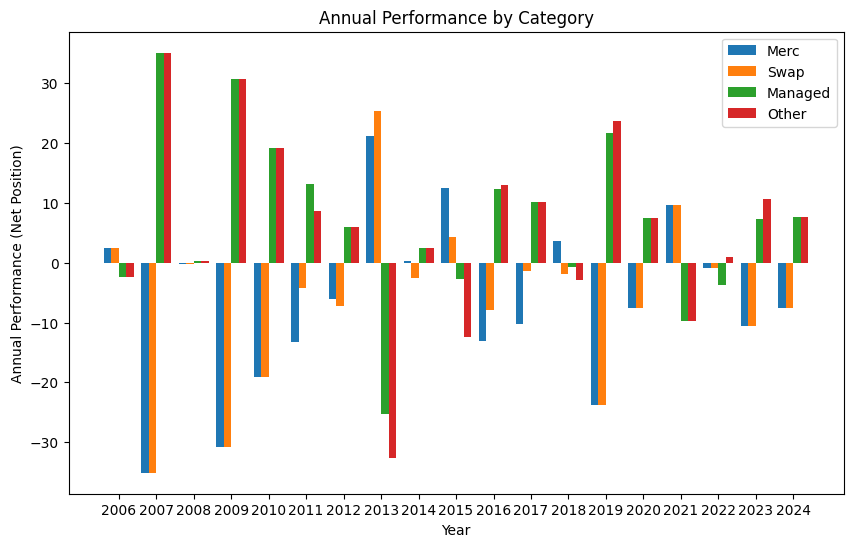

In [44]:
# Create bar chart for Net Position
fig, ax = plt.subplots(figsize=(10, 6))

# Draw bars for each category
bar_width = 0.2
index = annual_performance['Year']

bar1 = plt.bar(index, annual_performance['Merc Performance Net Pos'], bar_width, label='Merc')
bar2 = plt.bar(index + bar_width, annual_performance['Swap Performance Net Pos'], bar_width, label='Swap')
bar3 = plt.bar(index + 2 * bar_width, annual_performance['Managed Performance Net Pos'], bar_width, label='Managed')
bar4 = plt.bar(index + 3 * bar_width, annual_performance['Other Performance Net Pos'], bar_width, label='Other')

# Diagram settings
plt.xlabel('Year')
plt.ylabel('Annual Performance (Net Position)')
plt.title('Annual Performance by Category')
plt.xticks(index + 1.5 * bar_width, annual_performance['Year'])
plt.legend()

plt.show()

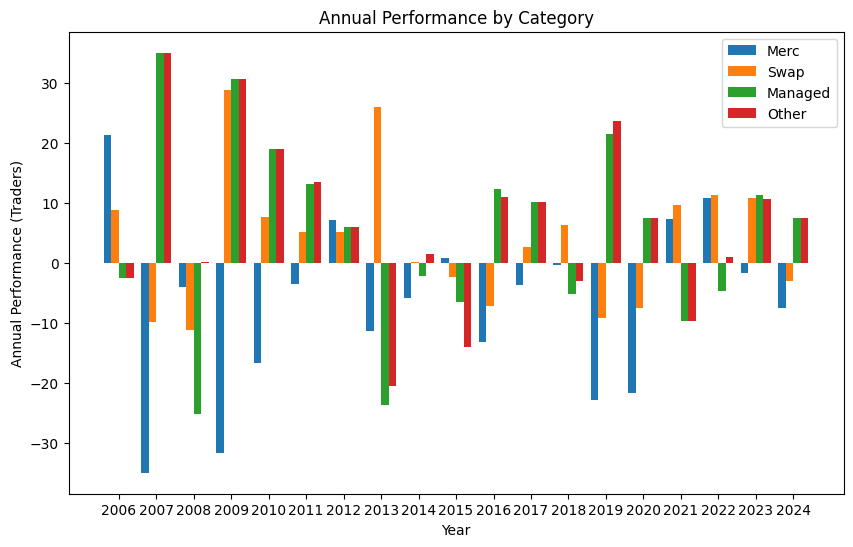

In [45]:
# Same for Trader
# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Draw bars for each category
bar_width = 0.2
index = annual_performance['Year']

bar1 = plt.bar(index, annual_performance['Merc Performance Traders'], bar_width, label='Merc')
bar2 = plt.bar(index + bar_width, annual_performance['Swap Performance Traders'], bar_width, label='Swap')
bar3 = plt.bar(index + 2 * bar_width, annual_performance['Managed Performance Traders'], bar_width, label='Managed')
bar4 = plt.bar(index + 3 * bar_width, annual_performance['Other Performance Traders'], bar_width, label='Other')

# Diagram settings
plt.xlabel('Year')
plt.ylabel('Annual Performance (Traders)')
plt.title('Annual Performance by Category')
plt.xticks(index + 1.5 * bar_width, annual_performance['Year'])
plt.legend()

plt.show()

In [46]:
# Merge
performance = quarterly_performance.merge(annual_performance, on='Year', suffixes=(' Quarterly', ' Annual'))
performance

Quarter  Merc Performance Net Pos Quarterly  \
0   2006Q2                           -0.814691   
1   2006Q3                            9.915714   
2   2006Q4                           -6.693329   
3   2007Q1                           -8.063871   
4   2007Q2                            3.333243   
..     ...                                 ...   
68  2023Q2                            4.171605   
69  2023Q3                            5.008884   
70  2023Q4                          -12.578980   
71  2024Q1                           -4.534046   
72  2024Q2                           -3.027891   

    Swap Performance Net Pos Quarterly  Managed Performance Net Pos Quarterly  \
0                            -0.814691                               0.814691   
1                             9.915714                              -9.915714   
2                            -6.693329                               6.693329   
3                            -8.063871                               8.063871   
4                             3.333243                              -3.333243   
..                                 ...                                    ...   
68                            4.171605                              -4.171605   
69                            5.008884                              -1.020247   
70                          -12.578980                               5.273643   
71                           -4.534046                               4.534046   
72                           -3.027891                               3.027891   

    Other Performance Net Pos Quarterly  Merc Performance Traders Quarterly  \
0                              0.814691                           -0.814691   
1                             -9.915714                           19.209760   
2                              6.693329                            2.930028   
3                              8.063871                           -6.787096   
4                             -3.333243                            2.179876   
..                                  ...                                 ...   
68                            -4.171605                            4.040275   
69                            -5.008884                            5.450655   
70                            12.578980                           -3.953183   
71                             4.534046                           -4.534046   
72                             3.027891                           -3.027891   

    Swap Performance Traders Quarterly  Managed Performance Traders Quarterly  \
0                            -0.814691                               0.814691   
1                             2.998387                              -9.915714   
2                             6.693329                               6.693329   
3                             7.441320                               8.063871   
4                            -3.219771                              -3.333243   
..                                 ...                                    ...   
68                            2.530311                              -4.171605   
69                           -1.872995                              -1.020247   
70                            7.305067                               9.263561   
71                            0.058554                               4.534046   
72                           -3.027891                               3.027891   

    Other Performance Traders Quarterly  Year  \
0                              0.814691  2006   
1                             -9.915714  2006   
2                              6.693329  2006   
3                              8.063871  2007   
4                             -3.333243  2007   
..                                  ...   ...   
68                            -4.171605  2023   
69                            -5.008884  2023   
70                            12.578980  2023   
71               

In [47]:
# CSV Export 
filepath = Path(your_data_path+timestamp+'_gold_cot_price_report_performance.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
performance.to_csv(filepath)

In [48]:
# Merge
df_cot_price_num_perf = df_cot_price_num.merge(performance, on='Quarter')

In [49]:
# CSV Export 
filepath = Path(your_data_path+timestamp+'_gold_cot_price_report_performance_incl.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df_cot_price_num_perf.to_csv(filepath)

In [50]:
# Convert the date column to datetime
df_cot_price_num_perf['Date'] = pd.to_datetime(df_cot_price_num_perf['Date'])

In [51]:
df_cot_price_num_perf

Unnamed: 0  As_of_Date_In_Form_YYMMDD       Date  \
0         64988                      60620 2006-06-20   
1         64985                      60711 2006-07-11   
2         64984                      60718 2006-07-18   
3         64983                      60725 2006-07-25   
4         64982                      60801 2006-08-01   
..          ...                        ...        ...   
857        4740                     240305 2024-03-05   
858        4739                     240312 2024-03-12   
859        4736                     240402 2024-04-02   
860        4735                     240409 2024-04-09   
861        4734                     240416 2024-04-16   

     CFTC_Contract_Market_Code  CFTC_Region_Code  CFTC_Commodity_Code  \
0                        88691                 1                   88   
1                        88691                 1                   88   
2                        88691                 1                   88   
3                        88691                 1                   88   
4                        88691                 1                   88   
..                         ...               ...                  ...   
857                      88691                 1                   88   
858                      88691                 1                   88   
859                      88691                 1                   88   
860                      88691                 1                   88   
861                      88691                 1                   88   

     Open_Interest_All  Prod_Merc_Positions_Long_All  \
0               288148                         29230   
1               312684                         34094   
2               324276                         30100   
3               315635                         34473   
4               304907                         29814   
..                 ...                           ...   
857             471616                         11650   
858             516057                         30471   
859             500045                         32235   
860             505214                         34191   
861             517193                         37797   

     Prod_Merc_Positions_Short_All  Swap_Positions_Long_All  \
0                           112900                    23091   
1                           114612                    23173   
2                           115518                    24180   
3                           118546                    25497   
4                           123870                    25970   
..                             ...                      ...   
857                          60537                    77009   
858                          78911                    75076   
859                          77122                    80217   
860                          76217                    79228   
861                          71700                    78012   

     Swap__Positions_Short_All  Swap__Positions_Spread_All  \
0                        61692                        6492   
1                        74702                        7141   
2                        78853                        9689   
3                        80913                        5491   
4                        70347                        4082   
..                         ...                         ...   
857                     234914                       15364   
858                     244909                       23885   
859                     261044                       14662   
860                     261784                       14675   
861                     266867                       16875   

     M_Money_Positions_Long_All  M_Money_Positions_Short_All  \
0                         91198                        30082   
1                        101019                        29135   
2                        105068                        25797   
3           

### <a id='toc1_1_5_'></a>[Data analysis](#toc0_)

**Comparison Gold Price / USD Price**

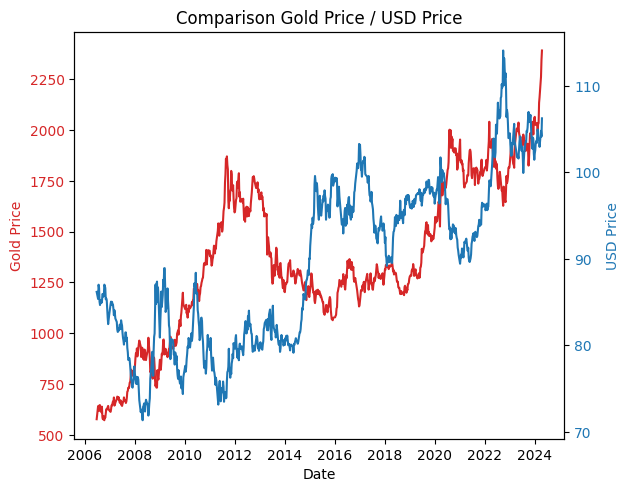

In [52]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color=color)
ax1.plot(df_cot_price_num_perf['Date'], df_cot_price_num_perf['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('USD Price', color=color)  # we already handled the x-label with ax1
ax2.plot(df_cot_price_num_perf['Date'], df_cot_price_num_perf['USDPrice'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparison Gold Price / USD Price')
plt.show()

**Comparison Gold Price / Global Economic Policy Uncertainty Index: Current Price Adjusted GDP**

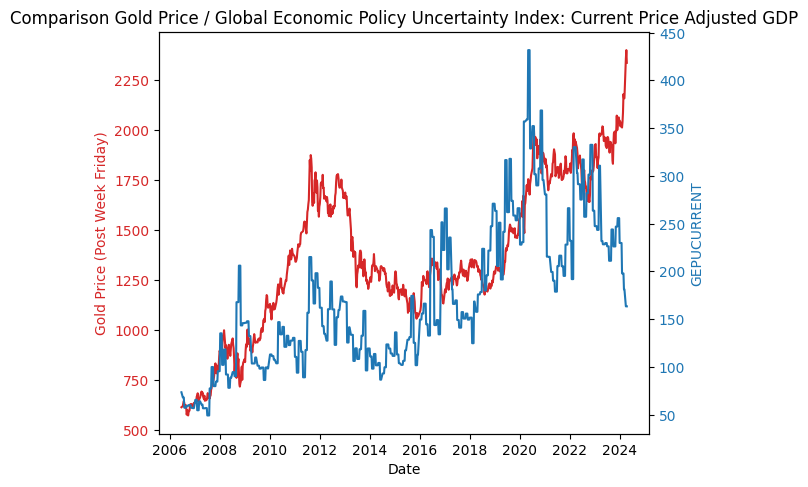

In [53]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'GEPUCURRENT'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Linear regression for the first trend line
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the second trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Global Economic Policy Uncertainty Index: Current Price Adjusted GDP')
plt.show()



***Comparison Gold Price / Oil Price (Post Week Friday)***

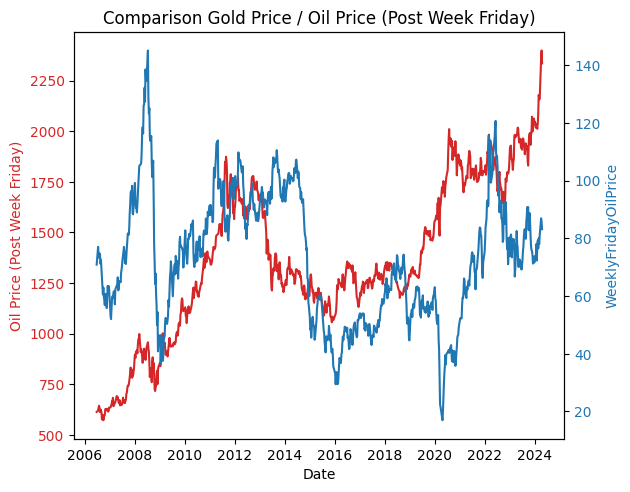

In [54]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'WeeklyFridayOilPrice'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')


# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Oil Price (Post Week Friday)')
plt.show()



**Comparison Gold Price (Post Week Friday) / Merc Net Position (ABS)**

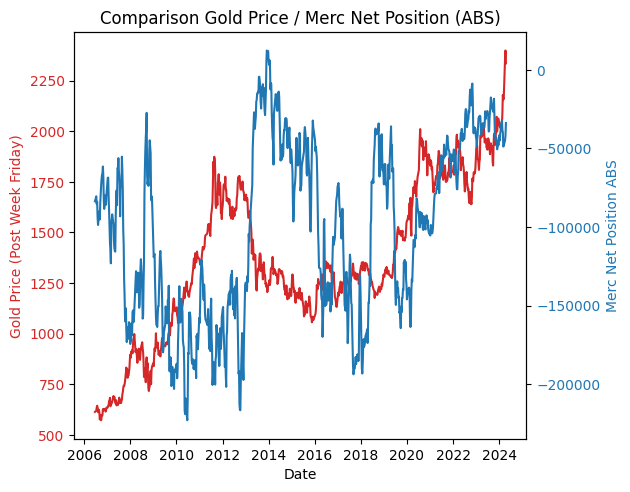

In [55]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'Merc Net Position ABS'
# iv = 'Swap Net Position ABS'
# iv = 'Commercials Net Position ABS'
# iv = 'NonCommercials Net Position ABS'
# iv = 'Managed Net Position ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Merc Net Position (ABS)')
plt.show()



**Comparison Gold Price (Post Week Friday) / Merc Traders (ABS)**

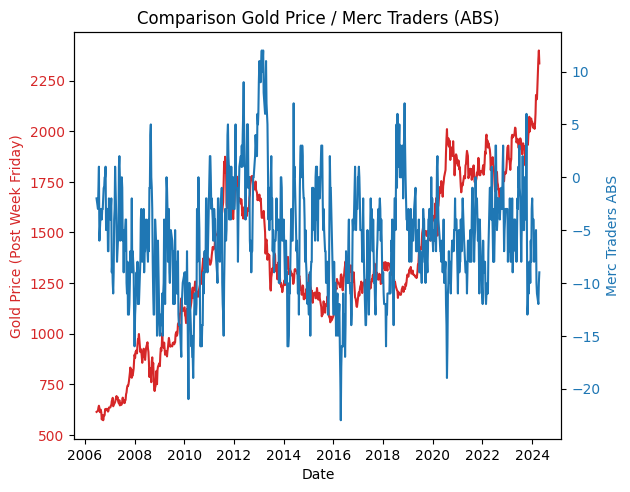

In [56]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'Merc Traders ABS'
# iv = 'Swap Net Position ABS'
# iv = 'Commercials Net Position ABS'
# iv = 'NonCommercials Net Position ABS'
# iv = 'Managed Net Position ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Merc Traders (ABS)')
plt.show()

**Comparison Gold Price (Post Week Friday) / Swap Net Position (ABS)**

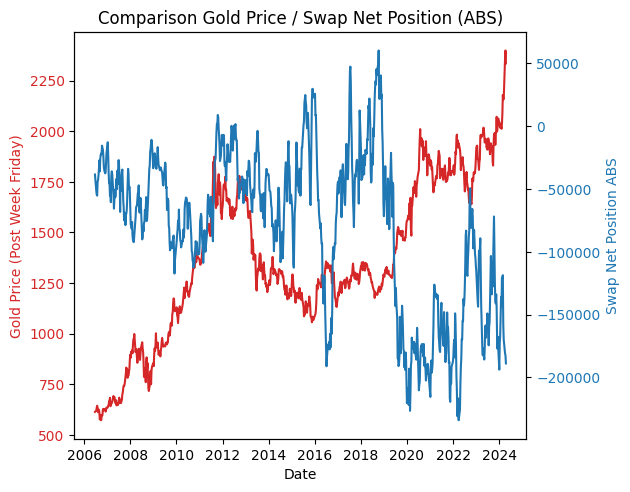

In [57]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

# iv = 'Merc Net Position ABS'
iv = 'Swap Net Position ABS'
# iv = 'Commercials Net Position ABS'
# iv = 'NonCommercials Net Position ABS'
# iv = 'Managed Net Position ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Swap Net Position (ABS)')
plt.show()



**Comparison Gold Price (Post Week Friday) / Swap Traders (ABS)**

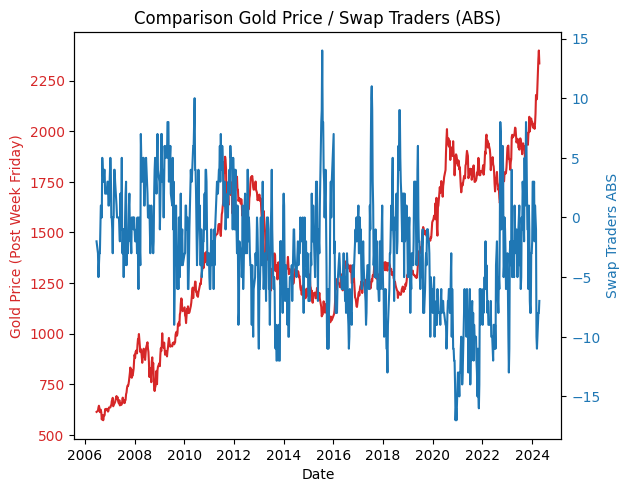

In [58]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'Swap Traders ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Swap Traders (ABS)')
plt.show()

**Comparison Gold Price (Post Week Friday) / Other Net Position (ABS)**

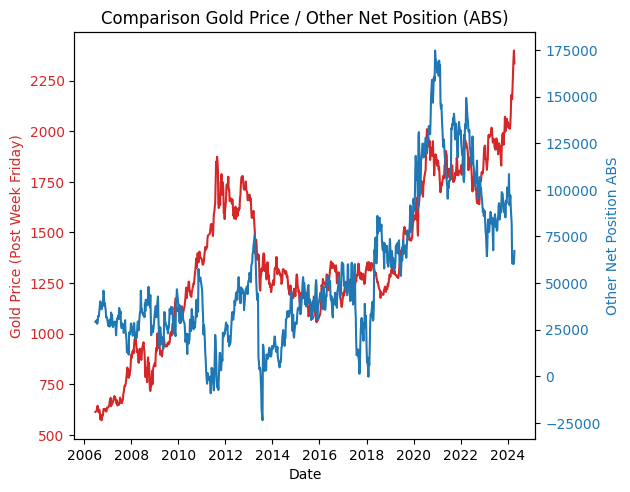

In [59]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

# iv = 'Merc Net Position ABS'
# iv = 'Commercials Net Position ABS'
# iv = 'NonCommercials Net Position ABS'
# iv = 'Managed Net Position ABS'
iv = 'Other Net Position ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.33, 0.5, 0.5))  # Legende für ax2
# ax2.legend(loc='best', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))  # Legende für ax1


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Other Net Position (ABS)')
plt.show()



**Comparison Gold Price (Post Week Friday) / Other Traders (ABS)**

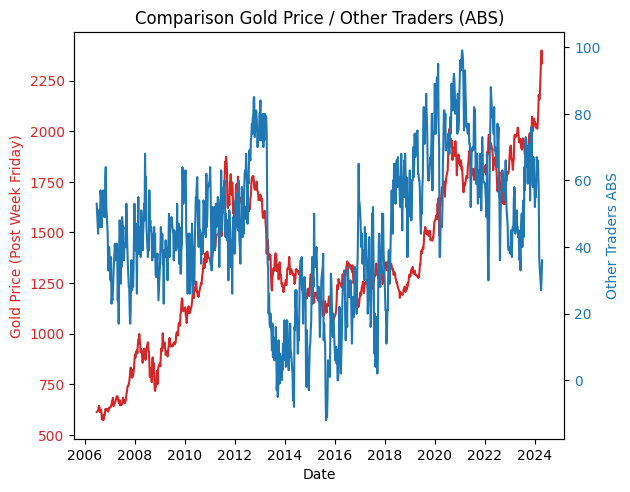

In [60]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'Other Traders ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Other Traders (ABS)')
plt.show()

**Comparison Gold Price (Post Week Friday) / Managed Net Position (ABS)**

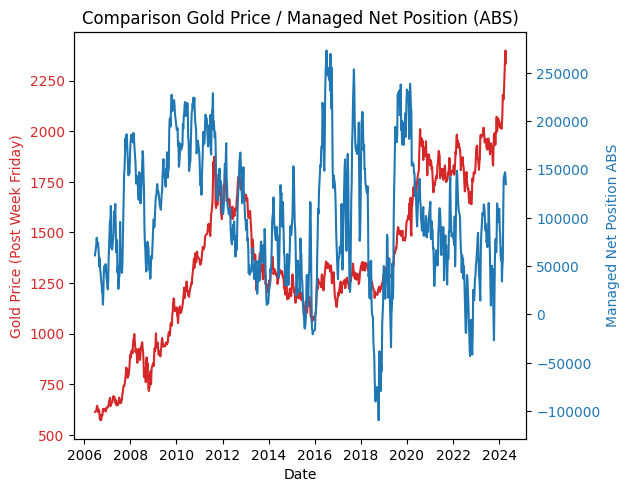

In [61]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

# iv = 'Merc Net Position ABS'
# iv = 'Commercials Net Position ABS'
# iv = 'NonCommercials Net Position ABS'
iv = 'Managed Net Position ABS'
# iv = 'Other Net Position ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.33, 0.5, 0.5))  # Legende für ax2
# ax2.legend(loc='best', bbox_to_anchor=(0.5, 0.1, 0.5, 0.5))  # Legende für ax1


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Managed Net Position (ABS)')
plt.show()

**Comparison Gold Price (Post Week Friday) / Managed Traders (ABS)**

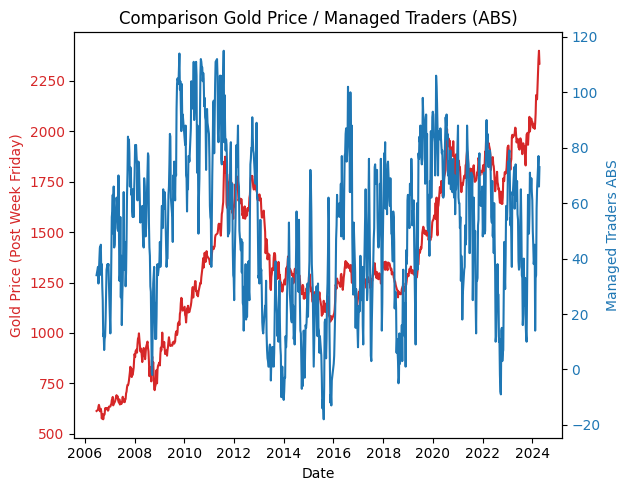

In [62]:
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

iv = 'Managed Traders ABS'

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price (Post Week Friday)', color=color)
# ax1.plot(subset['Date'], subset['WeeklyFridayPrice']-subset['Price'], color=color)
# ax1.plot(subset['Date'], subset['Post Week Price'], color=color)
ax1.plot(subset['Date'], subset['Post Week Friday Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(iv , color=color)  # we already handled the x-label with ax1
ax2.plot(subset['Date'], subset[iv], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Convert date data for the regression
x_numeric = (subset['Date'] - pd.Timestamp('1970-01-01')).dt.total_seconds() / 86400

# Convert date data for the regression
y1 = subset['Post Week Friday Price']
coefficients1 = np.polyfit(x_numeric, y1, 1)
polynomial1 = np.poly1d(coefficients1)
y1_fit = polynomial1(x_numeric)

# Linear regression for the first trend line
y2 = subset[iv]
coefficients2 = np.polyfit(x_numeric, y2, 1)
polynomial2 = np.poly1d(coefficients2)
y2_fit = polynomial2(x_numeric)

# Add trend line
# ax1.plot(subset['Date'], y1_fit, '--r', label='Trendlinie Post Week Friday Price')
# ax1.plot(subset['Date'], y1_fit, color='tab:red', label='Trendlinie WeeklyFridayPrice')
# ax2.plot(subset['Date'], y2_fit, '--b', label=f'Trendlinie {iv}')
# ax2.plot(subset['Date'], y2_fit, color='tab:blue', label=f'Trendlinie {iv}')

# ax1.legend(loc='upper left',bbox_to_anchor=(0.1, -0.1))  # Legende für ax1
# ax2.legend(loc='lower right',bbox_to_anchor=(0.1, -0.1))  # Legende für ax2

# ax1.legend(loc='best', bbox_to_anchor=(0.5, -0.3, 0.5, 0.4))  # Legende für ax1
# ax2.legend(loc='best', bbox_to_anchor=(0.5, -0.5, 0.5, 0.5))  # Legende für ax2


fig.tight_layout()  # Ensures that labels are not cut off
# plt.legend()
plt.title('Comparison Gold Price / Managed Traders (ABS)')
plt.show()

## <a id='toc1_2_'></a>[Feature evaluation](#toc0_)

**Analyse Features and their correlations to the desired Objects**

*Aim is to forecast price movement using specified features*

In [63]:
# Select only numeric columns for correlation calculation
numeric_df = df_cot_price_num_perf.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr = numeric_df.corr()

# If you're specifically interested in 'Change in price %' column
corr_with_change_in_price = corr[['WeeklyFridayPrice change to Post Week Friday Price %']].sort_values(by='WeeklyFridayPrice change to Post Week Friday Price %', ascending=False)

# Filter correlations (if needed)
filtered_corr = corr_with_change_in_price[corr_with_change_in_price['WeeklyFridayPrice change to Post Week Friday Price %'] > 0.2]

filtered_corr

WeeklyFridayPrice change to Post Week Friday Price %
WeeklyFridayPrice change to Post Week Friday Pr...                                           1.000000   
WeeklyFridayPrice change to Post Week Friday Pr...                                           0.950818   
Change to Post Week Price %                                                                  0.406273   
Change to Post Week Price ABS                                                                0.388029   
Other Performance Net Pos Quarterly                                                          0.233197   
Managed Performance Net Pos Quarterly                                                        0.232550   
Other Performance Traders Quarterly                                                          0.232547   
Managed Performance Traders Quarterly                                                        0.225350

Unfortunately, no feature correlates to a change in price %. Therefore a general direction 
of trading cannot be calculated using these features.

In [64]:
# Pearson correlation test
subset = df_cot_price_num_perf[(df_cot_price_num_perf['Date'] >= '2006-01-01') & (df_cot_price_num_perf['Date'] <= '2024-12-31')]

target = 'Post Week Friday Price'

feauters_to_check = [
    'Open_Interest_All',
    'Prod_Merc_Positions_Long_All',
    'Prod_Merc_Positions_Short_All',
    'Swap_Positions_Long_All',
    'Swap__Positions_Short_All',
    'Swap__Positions_Spread_All',
    'M_Money_Positions_Long_All',
    'M_Money_Positions_Short_All',
    'M_Money_Positions_Spread_All',
    'Other_Rept_Positions_Long_All',
    'Other_Rept_Positions_Short_All',
    'Other_Rept_Positions_Spread_All',
    'Tot_Rept_Positions_Long_All',
    'Tot_Rept_Positions_Short_All',
    'NonRept_Positions_Long_All',
    'NonRept_Positions_Short_All',
    'Pct_of_Open_Interest_All',
    'Pct_of_OI_Prod_Merc_Long_All',
    'Pct_of_OI_Prod_Merc_Short_All',
    'Pct_of_OI_Swap_Long_All',
    'Pct_of_OI_Swap_Short_All',
    'Pct_of_OI_Swap_Spread_All',
    'Pct_of_OI_M_Money_Long_All',
    'Pct_of_OI_M_Money_Short_All',
    'Pct_of_OI_M_Money_Spread_All',
    'Pct_of_OI_Other_Rept_Long_All',
    'Pct_of_OI_Other_Rept_Short_All',
    'Pct_of_OI_Other_Rept_Spread_All',
    'Pct_of_OI_Tot_Rept_Long_All',
    'Pct_of_OI_Tot_Rept_Short_All',
    'Pct_of_OI_NonRept_Long_All',
    'Pct_of_OI_NonRept_Short_All',
    'Traders_Tot_All',
    'Traders_Prod_Merc_Long_All',
    'Traders_Prod_Merc_Short_All',
    'Traders_Swap_Long_All',
    'Traders_Swap_Short_All',
    'Traders_Swap_Spread_All',
    'Traders_M_Money_Long_All',
    'Traders_M_Money_Short_All',
    'Traders_M_Money_Spread_All',
    'Traders_Other_Rept_Long_All',
    'Traders_Other_Rept_Short_All',
    'Traders_Other_Rept_Spread_All',
    'Traders_Tot_Rept_Long_All',
    'Traders_Tot_Rept_Short_All',
    'Conc_Gross_LE_4_TDR_Long_All',
    'Conc_Gross_LE_4_TDR_Short_All',
    'Conc_Gross_LE_8_TDR_Long_All',
    'Conc_Gross_LE_8_TDR_Short_All',
    'Conc_Net_LE_4_TDR_Long_All',
    'Conc_Net_LE_4_TDR_Short_All',
    'Conc_Net_LE_8_TDR_Long_All',
    'Conc_Net_LE_8_TDR_Short_All',
    'Price',
    'WeeklyFridayPrice',
    'USDPrice',
    'WeeklyFridayUSDPrice',
    'OilPrice',
    'WeeklyFridayOilPrice',
    'GEPUCURRENT',
    'Change to Friday Price ABS',
    'Change to Friday Price %',
    'Merc Net Position ABS',
    'Swap Net Position ABS',
    'Managed Net Position ABS',
    'Other Net Position ABS',
    'Merc Traders ABS',
    'Swap Traders ABS',
    'Managed Traders ABS',
    'Other Traders ABS',
    'Commercials Net Position ABS',
    'NonCommercials Net Position ABS',
    'Commercials Traders ABS',
    'NonCommercials Traders ABS',
    'Merc Net Position ABS change',
    'Merc % Change Net Position',
    'Swap Net Position ABS change',
    'Swap % Change Net Position',
    'Managed Net Position ABS change',
    'Managed % Change Net Position',
    'Other Net Position ABS change',
    'Other % Change Net Position',
    'Commercials Net Position ABS change',
    'Commercials % Change Net Position',
    'NonCommercials Net Position ABS change',
    'NonCommercials % Change Net Position',
    'Merc % of total Long',
    'Managed % of total Long',
    'Swap % of total Long',
    'Other % of total Long',
    'Merc % of total Short',
    'Managed % of total Short',
    'Swap % of total Short',
    'Other % of total Short'
]

# Initialize results
results = []

for indvar in feauters_to_check:
    correlation, p_value = stats.pearsonr(subset[indvar], subset[target])
    results.append((indvar, round(correlation, 4), round(p_value, 4)))

results_df = pd.DataFrame(results, columns=['Feature', 'Korrelationskoeffizient', 'P-Wert'])

# Sort results by correlation coefficient (descending)
sorted_by_corr = results_df.sort_values(by='Korrelationskoeffizient', ascending=False)

# Filter for absolute correlation coefficient > 0.1 and p-value < 0.05
filtered_df = sorted_by_corr[(sorted_by_corr['Korrelationskoeffizient'].abs() > 0.1) & (sorted_by_corr['P-Wert'] < 0.05)]

print("\nGefilterte Ergebnisse (|Korrelationskoeffizient| > 0.1 und P-Wert < 0.05):")

# Assuming df is your DataFrame
pd.set_option('display.max_rows', 100)

filtered_df


Gefilterte Ergebnisse (|Korrelationskoeffizient| > 0.1 und P-Wert < 0.05):


c:\Users\tbern\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Feature  Korrelationskoeffizient  P-Wert
55                WeeklyFridayPrice                   0.9964  0.0000
54                            Price                   0.9941  0.0000
36           Traders_Swap_Short_All                   0.7928  0.0000
37          Traders_Swap_Spread_All                   0.7692  0.0000
9     Other_Rept_Positions_Long_All                   0.7142  0.0000
60                      GEPUCURRENT                   0.6832  0.0000
20         Pct_of_OI_Swap_Short_All                   0.6607  0.0000
25    Pct_of_OI_Other_Rept_Long_All                   0.6594  0.0000
90            Other % of total Long                   0.6562  0.0000
4         Swap__Positions_Short_All                   0.6562  0.0000
35            Traders_Swap_Long_All                   0.6470  0.0000
40       Traders_M_Money_Spread_All                   0.6442  0.0000
93            Swap % of total Short                   0.6312  0.0000
66           Other Net Position ABS                   0.6052  0.0000
44        Traders_Tot_Rept_Long_All                   0.5787  0.0000
32                  Traders_Tot_All                   0.5161  0.0000
41      Traders_Other_Rept_Long_All                   0.5104  0.0000
3           Swap_Positions_Long_All                   0.5051  0.0000
56                         USDPrice                   0.4564  0.0000
57             WeeklyFridayUSDPrice                   0.4554  0.0000
70                Other Traders ABS                   0.4427  0.0000
12      Tot_Rept_Positions_Long_All                   0.4367  0.0000
0                 Open_Interest_All                   0.4303  0.0000
13     Tot_Rept_Positions_Short_All                   0.4295  0.0000
89             Swap % of total Long                   0.4275  0.0000
19          Pct_of_OI_Swap_Long_All                   0.4160  0.0000
10   Other_Rept_Positions_Short_All                   0.3695  0.0000
74       NonCommercials Traders ABS                   0.3664  0.0000
45       Traders_Tot_Rept_Short_All                   0.3652  0.0000
38         Traders_M_Money_Long_All                   0.3610  0.0000
72  NonCommercials Net Position ABS                   0.3359  0.0000
26   Pct_of_OI_Other_Rept_Short_All                   0.2643  0.0000
94           Other % of total Short                   0.2569  0.0000
28      Pct_of_OI_Tot_Rept_Long_All                   0.2406  0.0000
29     Pct_of_OI_Tot_Rept_Short_All                   0.2335  0.0000
69              Managed Traders ABS                   0.1811  0.0000
14       NonRept_Positions_Long_All                   0.1729  0.0000
63            Merc Net Position ABS                   0.1619  0.0000
7       M_Money_Positions_Short_All                   0.1513  0.0000
11  Other_Rept_Positions_Spread_All                   0.1510  0.0000
39        Traders_M_Money_Short_All                   0.1493  0.0000
67                 Merc Traders ABS                   0.1141  0.0008
5        Swap__Positions_Spread_All                   0.1137  0.0008
6        M_Money_Positions_Long_All                   0.1090  0.0013
58                         OilPrice                   0.1043  0.0022
52       Conc_Net_LE_8_TDR_Long_All                   0.1021  0.0027
51      Conc_Net_LE_4_TDR_Short_All                  -0.1302  0.0001
22       Pct_of_OI_M_Money_Long_All                  -0.1435  0.0000
88          Managed % of total Long                  -0.1536  0.0000
27  Pct_of_OI_Other_Rept_Spread_All                  -0.1651  0.0000
73          Commercials Traders ABS                  -0.1736  0.0000
31      Pct_of_OI_NonRept_Short_All                  -0.2335  0.0000
2     Prod_Merc_Positions_Short_All                  -0.2393  0.0000
30       Pct_of_OI_NonRept_Long_All                  -0.2406  0.0000
1      Prod_Merc_Positions_Long_All                  -0.2768  0.0000
71     Commercials Net Position ABS                  -0.3181  0.0000
33       Traders_Prod_Merc_Long_All                  -0.3595  0.0000
17     Pct_of_OI_Prod_Merc

Various features now have a strong correlation to the post week price,
,meaning we could potentially calculate the price movement.

Serveral features will not be used in my algorithm. This is purely because,
COT report data is the desired features to be analysed, not price
action data. 

Using Price and COT features to predict post week price is the aim

**Data Visulisation of Choosen Correlating Features**

<Axes: xlabel='Price', ylabel='Post Week Friday Price'>

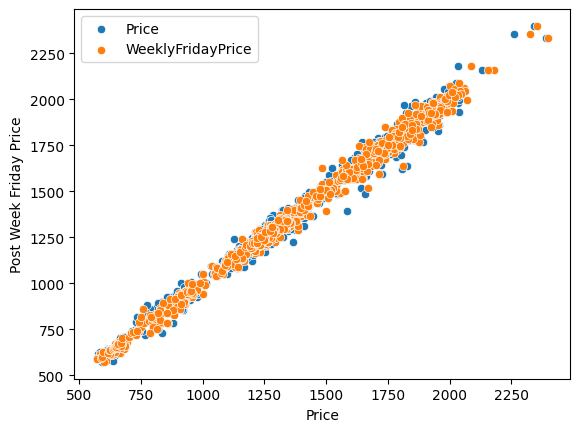

In [65]:
sns.scatterplot(data=df_cot_price_num_perf,x="Price",y="Post Week Friday Price",label = "Price")
sns.scatterplot(data=df_cot_price_num_perf,x="WeeklyFridayPrice",y="Post Week Friday Price",label="WeeklyFridayPrice")

<Axes: xlabel='Merc Net Position ABS', ylabel='Post Week Friday Price'>

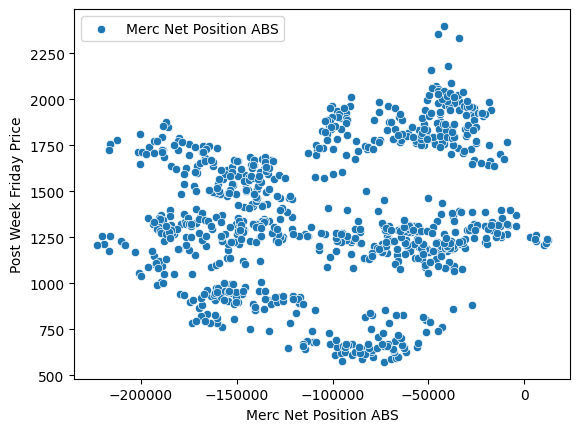

In [66]:
sns.scatterplot(data=df_cot_price_num_perf,x="Merc Net Position ABS",y="Post Week Friday Price",label='Merc Net Position ABS')

<Axes: xlabel='Change to Friday Price ABS', ylabel='Post Week Friday Price'>

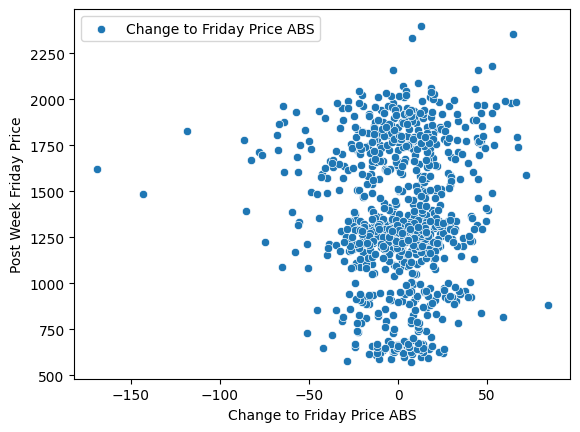

In [67]:
sns.scatterplot(data=df_cot_price_num_perf,x="Change to Friday Price ABS",y="Post Week Friday Price",label='Change to Friday Price ABS')

<Axes: xlabel='WeeklyFridayOilPrice', ylabel='Post Week Friday Price'>

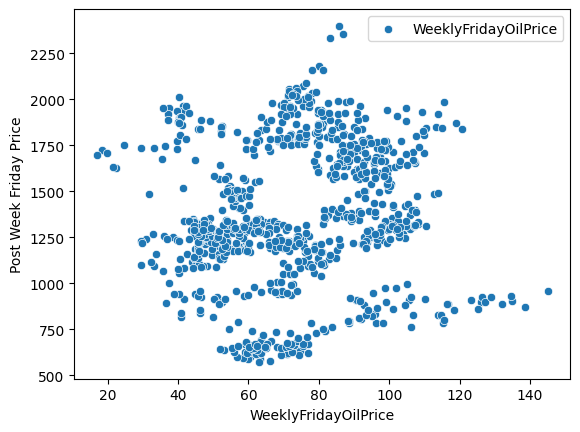

In [68]:
sns.scatterplot(data=df_cot_price_num_perf,x="WeeklyFridayOilPrice",y="Post Week Friday Price",label='WeeklyFridayOilPrice')

<Axes: xlabel='GEPUCURRENT', ylabel='Post Week Friday Price'>

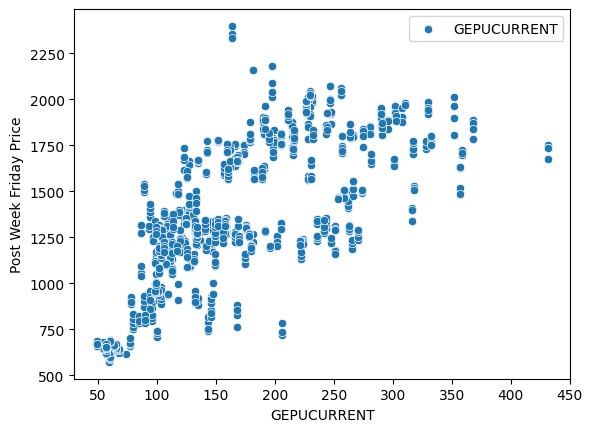

In [69]:
sns.scatterplot(data=df_cot_price_num_perf,x="GEPUCURRENT",y="Post Week Friday Price",label='GEPUCURRENT')

<Axes: xlabel='Other Traders ABS', ylabel='Post Week Friday Price'>

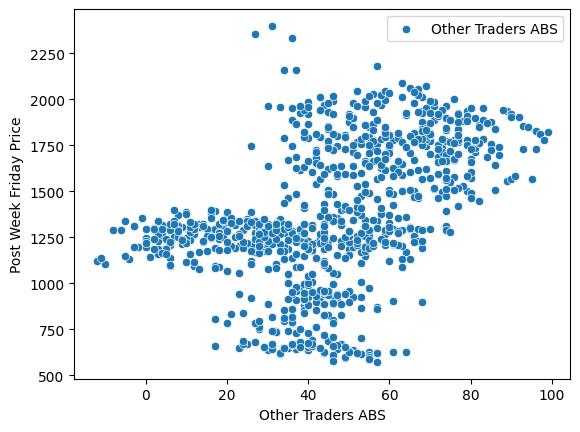

In [70]:
sns.scatterplot(data=df_cot_price_num_perf,x="Other Traders ABS",y="Post Week Friday Price",label='Other Traders ABS')

<Axes: xlabel='Open_Interest_All', ylabel='Post Week Friday Price'>

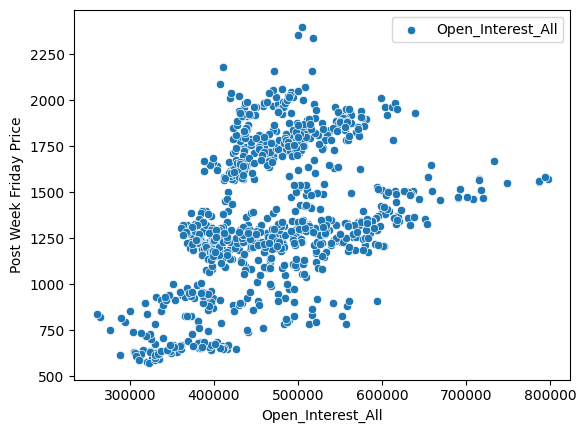

In [71]:
sns.scatterplot(data=df_cot_price_num_perf,x="Open_Interest_All",y="Post Week Friday Price",label='Open_Interest_All')

<Axes: xlabel='Other Net Position ABS', ylabel='Post Week Friday Price'>

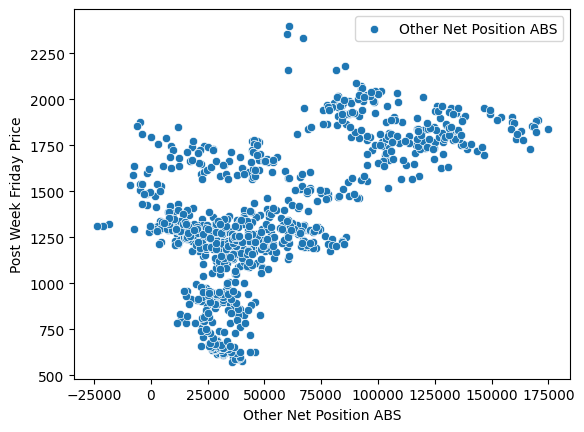

In [72]:
sns.scatterplot(data=df_cot_price_num_perf,x="Other Net Position ABS",y="Post Week Friday Price",label='Other Net Position ABS')

In [73]:
selected_indvar = [
    "WeeklyFridayPrice",
    "Price",
    "Merc Net Position ABS",
    "Change to Friday Price ABS",
    "WeeklyFridayOilPrice",
    "GEPUCURRENT",
    "Other Traders ABS",
    "Open_Interest_All",
    "Other Net Position ABS",
]

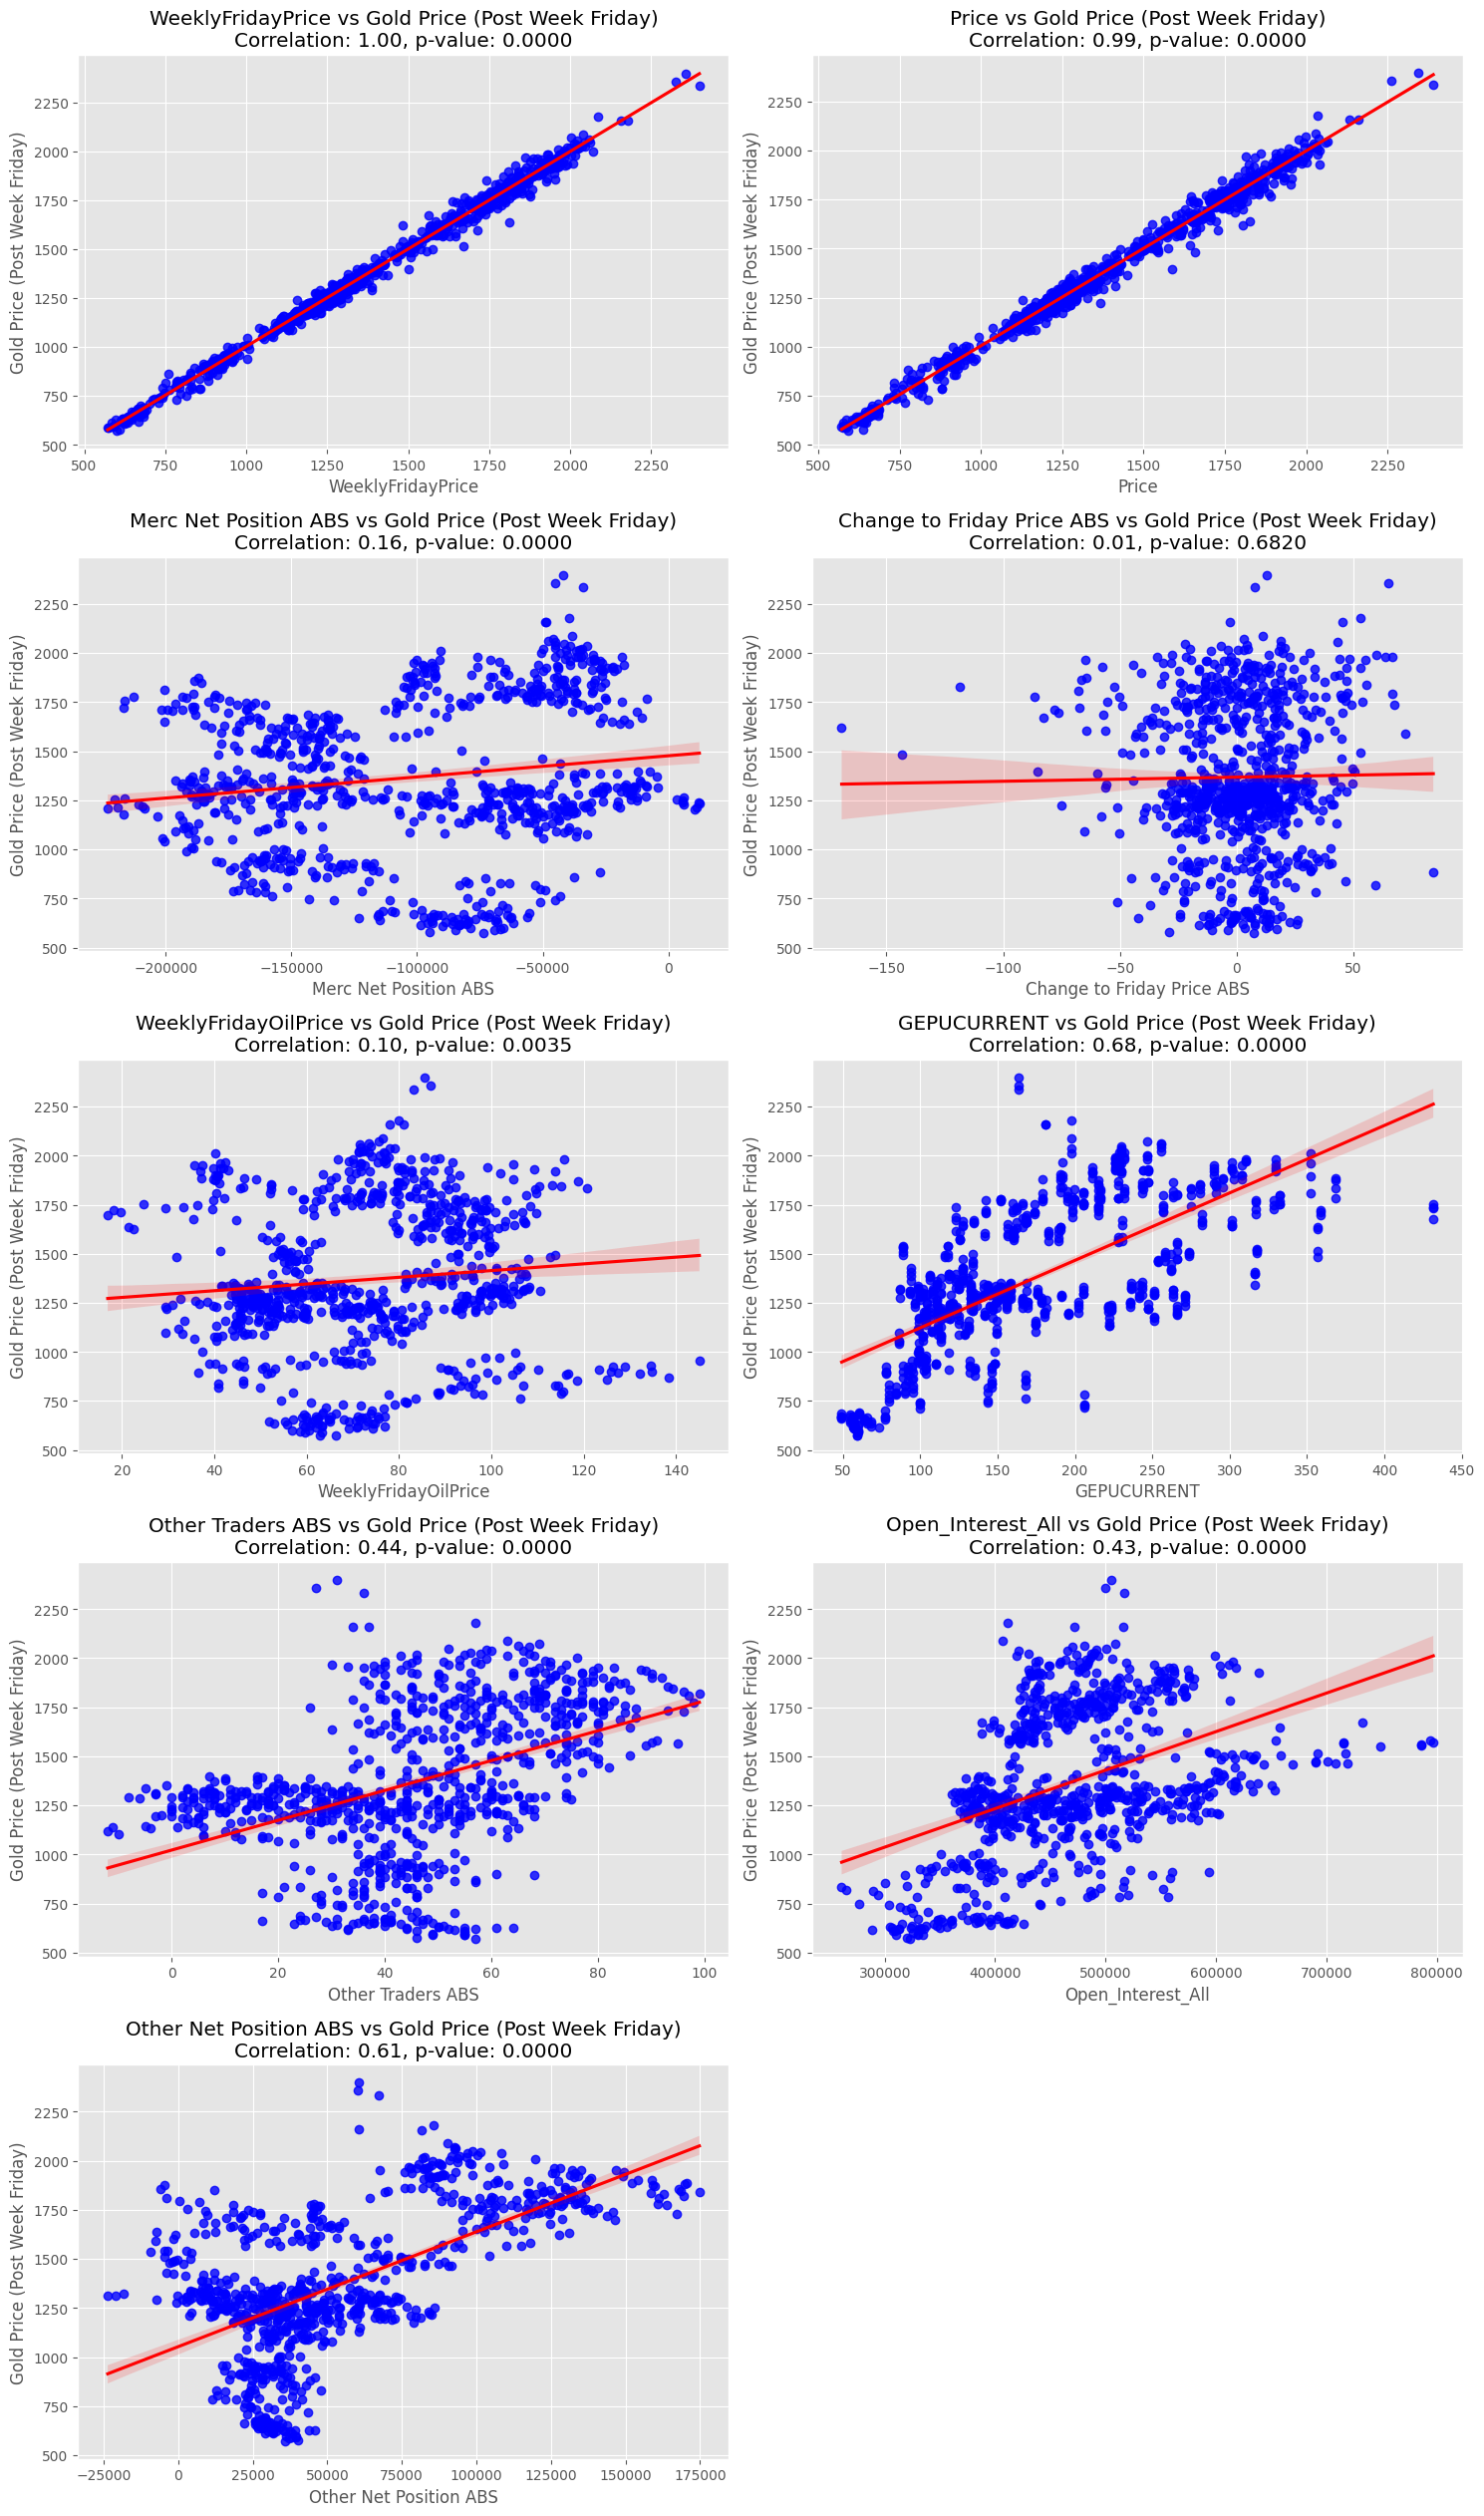

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# Define the independent variables (features) and the dependent variable (target variable)
indvar_liste = selected_indvar

target = 'Post Week Friday Price'  # Assumption: This is the target variable

# Extract the features and the target variable from the DataFrame
X = df_cot_price_num_perf[indvar_liste]
y = df_cot_price_num_perf[target]

# Generate scatter plots of the independent vs. dependent variables with correlation
plt.style.use('ggplot')
fig = plt.figure(figsize=(15, 40))

for index, feature_name in enumerate(indvar_liste):
    ax = fig.add_subplot(8, 2, index + 1)
    sns.regplot(x=X[feature_name], y=y, ax=ax, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
    corr, p_value = pearsonr(X[feature_name], y)
    ax.set_ylabel('Gold Price (Post Week Friday)', size=12)
    ax.set_xlabel(feature_name, size=12)
    ax.set_title(f'{feature_name} vs Gold Price (Post Week Friday)\nCorrelation: {corr:.2f}, p-value: {p_value:.4f}')

plt.tight_layout()
plt.show()

## <a id='toc1_3_'></a>[Creating a Linear Regression Model](#toc0_)

In [75]:
# initiate multiple linear regression
from statsmodels.regression import linear_model
from statsmodels.formula.api import ols
import statsmodels.api as sm
# Metric for evaluation
import sklearn.metrics as metrics

In [76]:
# Create x (independant) and y (dependant) variables for LinearRegression Model
X = df_cot_price_num_perf[selected_indvar]
y = df_cot_price_num_perf[['Post Week Friday Price']]

In [77]:
X.dropna()
X.isna().sum()

WeeklyFridayPrice             0
Price                         0
Merc Net Position ABS         0
Change to Friday Price ABS    0
WeeklyFridayOilPrice          0
GEPUCURRENT                   0
Other Traders ABS             0
Open_Interest_All             0
Other Net Position ABS        0
dtype: int64

In [78]:
# Creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = .3, # 30% of data for testing
                                                   shuffle = True, # Shuffling values
                                                   random_state = 42)

In [79]:
# Adding a Constant term for the Intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [80]:
# Fitting model
model = sm.OLS(y_train, X_train).fit()
print(model.summary(alpha = 0.05))

                              OLS Regression Results                              
Dep. Variable:     Post Week Friday Price   R-squared:                       0.993
Model:                                OLS   Adj. R-squared:                  0.993
Method:                     Least Squares   F-statistic:                 1.021e+04
Date:                    Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                            19:23:55   Log-Likelihood:                -2943.4
No. Observations:                     603   AIC:                             5905.
Df Residuals:                         594   BIC:                             5944.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [81]:
# Predicting on training and testing set
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluating the model
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
train_r2 = metrics.r2_score(y_train, y_train_pred)

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
test_r2 = metrics.r2_score(y_test, y_test_pred)

# Shows regression evaluation metrics
print('Train MAE: {}'.format(train_mae))
print('Train MSE: {}'.format(train_mse))
print('Train RMSE: {}'.format(train_rmse))
print('Train R2: {}'.format(train_r2))
print()
print('Test MAE: {}'.format(test_mae))
print('Test MSE: {}'.format(test_mse))
print('Test RMSE: {}'.format(test_rmse))
print('Test R2: {}'.format(test_r2))


Train MAE: 23.78773529792883
Train MSE: 1017.0139540416701
Train RMSE: 31.890656218423448
Train R2: 0.9927788535073652

Test MAE: 22.644024850716207
Test MSE: 1047.377885784235
Test RMSE: 32.363218099939246
Test R2: 0.9928474572690439


In [82]:
model.params

const                         13.211271
WeeklyFridayPrice              0.661734
Price                          0.334052
Merc Net Position ABS          0.000019
Change to Friday Price ABS     0.327682
WeeklyFridayOilPrice          -0.085492
GEPUCURRENT                    0.034730
Other Traders ABS              0.062835
Open_Interest_All             -0.000003
Other Net Position ABS        -0.000085
dtype: float64

Shapiro-Wilk Teststatistik: 0.938363790512085
Shapiro-Wilk p-Wert: 6.034097665974514e-09


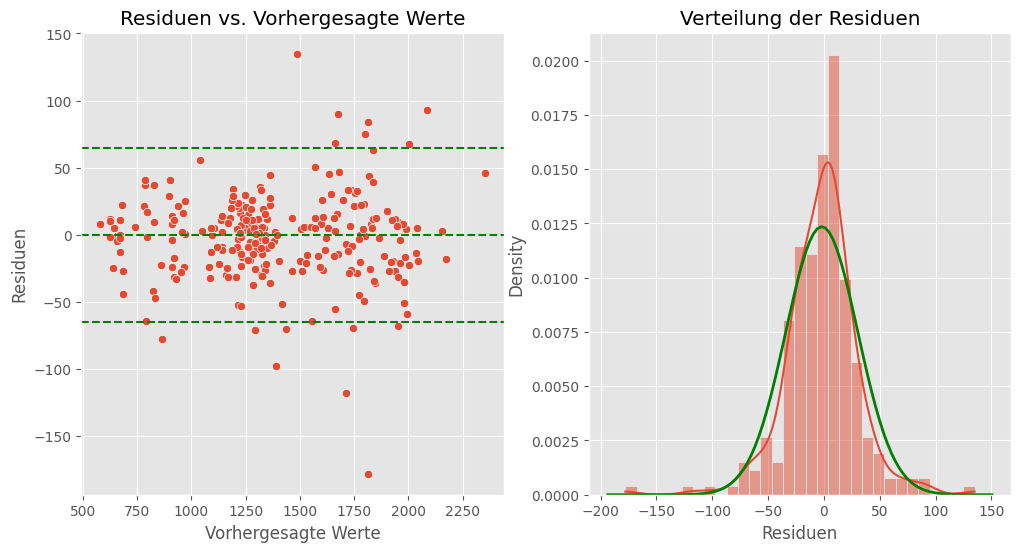

<Figure size 600x600 with 0 Axes>

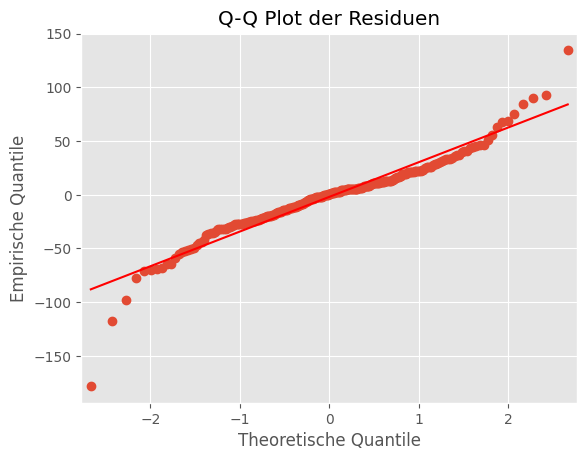

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, norm

# Calculation of the residuals
predictions = y_test_pred.values.flatten()  # Flatten to ensure 1-dimensional array
residuals = y_test.values.flatten() - y_test_pred.values.flatten()
std_residuals = np.std(residuals)


# Check for linearity and homoscedasticity
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=predictions, y=residuals)
plt.title('Residuen vs. Vorhergesagte Werte')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Residuen')
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=2 * std_residuals, color='g', linestyle='--')
plt.axhline(y=-2 * std_residuals, color='g', linestyle='--')


# Checking the normal distribution of the residuals
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, stat="density")
plt.title('Verteilung der Residuen')
plt.xlabel('Residuen')

# Plot of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, p, 'g', linewidth=2)


# Shapiro-Wilk test for normal distribution of residuals
shapiro_stat, shapiro_p_value = shapiro(residuals)

print(f'Shapiro-Wilk Teststatistik: {shapiro_stat}')
print(f'Shapiro-Wilk p-Wert: {shapiro_p_value}')

plt.show()

# Create Q-Q-Plot
plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot der Residuen')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Empirische Quantile')

plt.show()

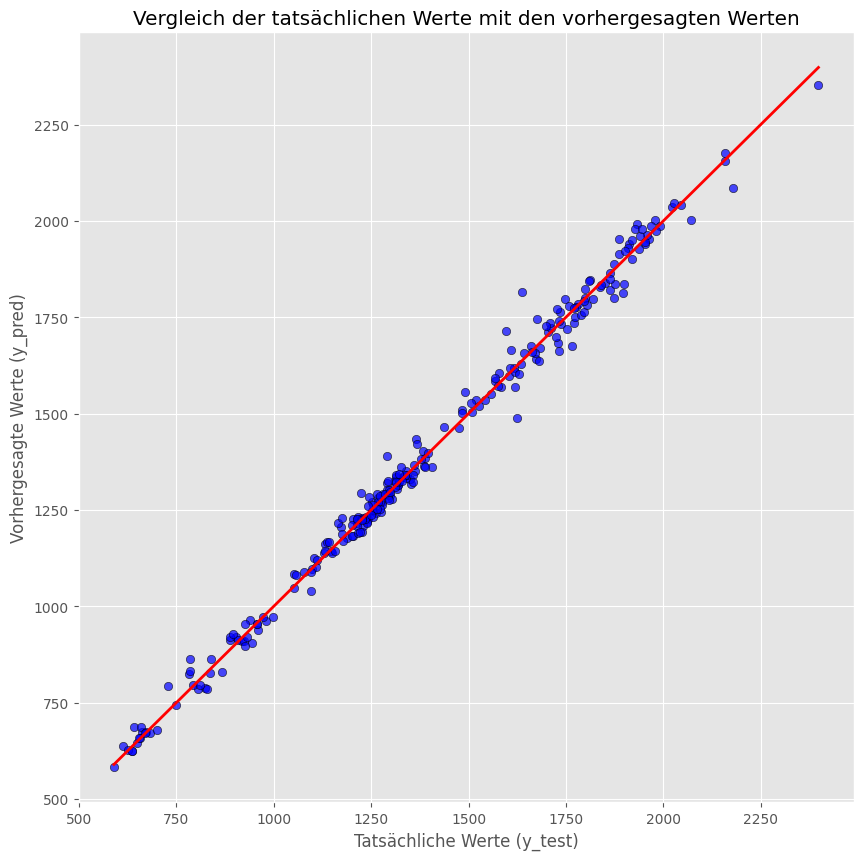

In [84]:
import matplotlib.pyplot as plt

# Visueller Vergleich der vorhergesagten Werte mit den tatsächlichen Werten
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_test_pred, c='blue', label='Datenpunkte', marker='o', edgecolor='k', alpha=0.7)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2)
plt.xlabel('Tatsächliche Werte (y_test)')
plt.ylabel('Vorhergesagte Werte (y_pred)')
plt.title('Vergleich der tatsächlichen Werte mit den vorhergesagten Werten')
plt.grid(True)
plt.show()

In [85]:
# Multicollinearity

# Calculation of Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Add interpretation of the VIF values
def interpret_vif(vif):
    if vif == 1:
        return "Keine Korrelation"
    elif 1 < vif < 5:
        return "Moderate Korrelation"
    elif 5 <= vif < 10:
        return "Hohe Korrelation"
    else:
        return "Sehr hohe Korrelation"

vif_data["Interpretation"] = vif_data["VIF"].apply(interpret_vif)

vif_data

c:\Users\tbern\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature        VIF         Interpretation
0           WeeklyFridayPrice        inf  Sehr hohe Korrelation
1                       Price        inf  Sehr hohe Korrelation
2       Merc Net Position ABS  11.067660  Sehr hohe Korrelation
3  Change to Friday Price ABS        inf  Sehr hohe Korrelation
4        WeeklyFridayOilPrice  15.403944  Sehr hohe Korrelation
5                 GEPUCURRENT  20.974395  Sehr hohe Korrelation
6           Other Traders ABS  15.729892  Sehr hohe Korrelation
7           Open_Interest_All  47.077774  Sehr hohe Korrelation
8      Other Net Position ABS  15.203696  Sehr hohe Korrelation

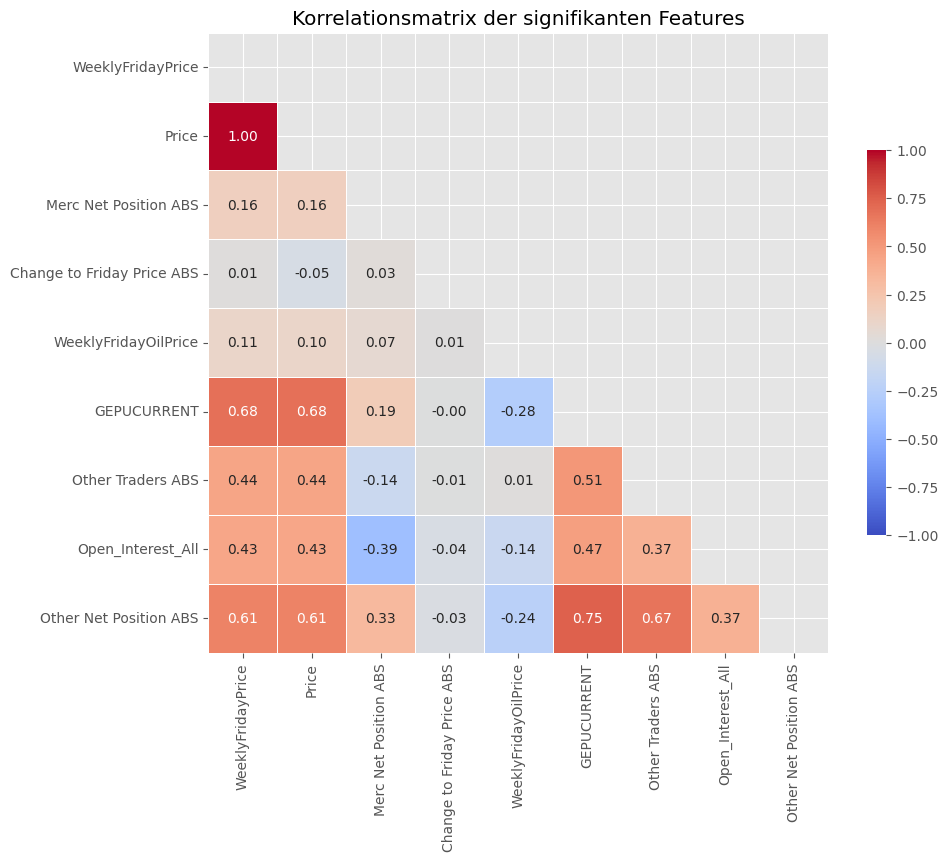

In [86]:
# Compute the Pearson correlation matrix
corr_matrix = subset[selected_indvar].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap with both color and size encoding the strength of correlations
plt.figure(figsize=(10, 10))
# sns.set(style='white')

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Korrelationsmatrix der signifikanten Features')
plt.show()

## <a id='toc1_4_'></a>[Biased Linear Regression Models](#toc0_)

In [87]:
# Create x (independant) and y (dependant) variables for LinearRegression Model
X = df_cot_price_num_perf[selected_indvar]
y = df_cot_price_num_perf[['Post Week Friday Price']]

In [88]:
X.dropna()
X.isna().sum()

WeeklyFridayPrice             0
Price                         0
Merc Net Position ABS         0
Change to Friday Price ABS    0
WeeklyFridayOilPrice          0
GEPUCURRENT                   0
Other Traders ABS             0
Open_Interest_All             0
Other Net Position ABS        0
dtype: int64

In [89]:
# Creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = .3, # 30% of data for testing
                                                   shuffle = True, # Shuffling values
                                                   random_state = 42)

In [90]:
# Adding a Constant term for the Intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [91]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# StandardScaler initialisieren und anpassen
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Ridge Regression Grid Search
ridge = Ridge()
ridge_params = {'alpha': [0, 1.0, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge = ridge_grid.best_estimator_

# Lasso Regression Grid Search
lasso = Lasso(max_iter=50000)
lasso_params = {'alpha': [0, 1.0, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=10, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso = lasso_grid.best_estimator_

# Elastic Net Regression Grid Search
elastic_net = ElasticNet(max_iter=50000)
elastic_net_params = {'alpha': [0, 0.5, 1], 'l1_ratio': [0, 0.5, 1]}
elastic_net_grid = GridSearchCV(elastic_net, elastic_net_params, cv=10, scoring='neg_mean_squared_error')
elastic_net_grid.fit(X_train, y_train)
best_elastic_net = elastic_net_grid.best_estimator_

# Beste Modelle anzeigen
print("Bestes Ridge Modell:", best_ridge)
print("Bestes Lasso Modell:", best_lasso)
print("Bestes Elastic Net Modell:", best_elastic_net)

# Vorhersagen mit den besten Modellen
y_pred_ridge = best_ridge.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)
y_pred_elastic_net = best_elastic_net.predict(X_test)

# Evaluation der Modelle
print("\nEvaluation der Modelle mit den besten Hyperparametern:")
print(f'Ridge Mean Squared Error: {mean_squared_error(y_test, y_pred_ridge)}')
print(f'Ridge R-squared: {r2_score(y_test, y_pred_ridge)}')
print(f'Lasso Mean Squared Error: {mean_squared_error(y_test, y_pred_lasso)}')
print(f'Lasso R-squared: {r2_score(y_test, y_pred_lasso)}')
print(f'Elastic Net Mean Squared Error: {mean_squared_error(y_test, y_pred_elastic_net)}')
print(f'Elastic Net R-squared: {r2_score(y_test, y_pred_elastic_net)}')

# Optional: Anzeigen der besten Parameter
print("\nBeste Parameter:")
print(f'Ridge: {ridge_grid.best_params_}')
print(f'Lasso: {lasso_grid.best_params_}')
print(f'Elastic Net: {elastic_net_grid.best_params_}')


c:\Users\tbern\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\tbern\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\tbern\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e+05, tolerance: 7.752e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

Bestes Ridge Modell: Ridge(alpha=100)
Bestes Lasso Modell: Lasso(alpha=100, max_iter=50000)
Bestes Elastic Net Modell: ElasticNet(alpha=1, l1_ratio=1, max_iter=50000)

Evaluation der Modelle mit den besten Hyperparametern:
Ridge Mean Squared Error: 1047.3768133721126
Ridge R-squared: 0.9928474645925455
Lasso Mean Squared Error: 1049.0567781511156
Lasso R-squared: 0.9928359921144347
Elastic Net Mean Squared Error: 1046.9084047581973
Elastic Net R-squared: 0.9928506633545893

Beste Parameter:
Ridge: {'alpha': 100}
Lasso: {'alpha': 100}
Elastic Net: {'alpha': 1, 'l1_ratio': 1}


In [92]:
''' 
    Baseline Model

''' 
# Fitting model
model = sm.OLS(y_train, X_train)
model_result = model.fit()

predictions = model_result.predict(X_test)

print(model_result.summary(alpha = 0.05))
print('OLS params:')
print(model_result.params)

# Shows regression evaluation metrics
print('MAE: {}'.format(metrics.mean_absolute_error(y_test, predictions)))
print('MSE: {}'.format(metrics.mean_squared_error(y_test, predictions)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('r2: {}'.format(metrics.r2_score(y_test, predictions)))

                              OLS Regression Results                              
Dep. Variable:     Post Week Friday Price   R-squared:                       0.993
Model:                                OLS   Adj. R-squared:                  0.993
Method:                     Least Squares   F-statistic:                 1.021e+04
Date:                    Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                            19:24:04   Log-Likelihood:                -2943.4
No. Observations:                     603   AIC:                             5905.
Df Residuals:                         594   BIC:                             5944.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [93]:
''' 
    Regularized Model Elastic Net

''' 
# Now, use the fit_regularized method
# olsmodel2 = model.fit_regularized(method='elastic_net', alpha=0.5, L1_wt=0.2, start_params=model_result.params.to_numpy()) # Elastic Net
olsmodel2 = model.fit_regularized(method='elastic_net', alpha=1, L1_wt=1, start_params=model_result.params.to_numpy()) # Elastic Net
# olsmodel2 = model.fit_regularized(method='elastic_net', alpha=1, L1_wt=1, start_params=model_result.params.to_numpy()) # Lasso
# olsmodel2 = model.fit_regularized(method='elastic_net', alpha=1, L1_wt=0.1, start_params=model_result.params.to_numpy()) # Ridge

final = sm.regression.linear_model.OLSResults(model, olsmodel2.params.to_numpy(), model.normalized_cov_params)

predictions = final.predict(X_test)


print(final.summary())
print('OLS fit_regularized params:')
print(olsmodel2.params)

#Shows regression evaluation metrics
print('MAE: {}'.format(metrics.mean_absolute_error(y_test, predictions)))
print('MSE: {}'.format(metrics.mean_squared_error(y_test, predictions)))
print('RMSE: {}'.format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))
print('r2: {}'.format(metrics.r2_score(y_test, predictions)))

                              OLS Regression Results                              
Dep. Variable:     Post Week Friday Price   R-squared:                       0.993
Model:                                OLS   Adj. R-squared:                  0.993
Method:                     Least Squares   F-statistic:                 1.017e+04
Date:                    Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                            19:24:04   Log-Likelihood:                -2944.6
No. Observations:                     603   AIC:                             5907.
Df Residuals:                         594   BIC:                             5947.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [94]:
# Predicting on training and testing set
y_train_pred = olsmodel2.predict(X_train)
y_test_pred = olsmodel2.predict(X_test)

# Evaluating the model
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
train_r2 = metrics.r2_score(y_train, y_train_pred)

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
test_r2 = metrics.r2_score(y_test, y_test_pred)

#Shows regression evaluation metrics
print('Train MAE: {}'.format(train_mae))
print('Train MSE: {}'.format(train_mse))
print('Train RMSE: {}'.format(train_rmse))
print('Train R2: {}'.format(train_r2))
print()
print('Test MAE: {}'.format(test_mae))
print('Test MSE: {}'.format(test_mse))
print('Test RMSE: {}'.format(test_rmse))
print('Test R2: {}'.format(test_r2))


Train MAE: 23.80438359564736
Train MSE: 1021.1069846169422
Train RMSE: 31.954764662205577
Train R2: 0.9927497915920734

Test MAE: 22.796669530255528
Test MSE: 1052.1969506123096
Test RMSE: 32.43758546211955
Test R2: 0.9928145478792488


## <a id='toc1_5_'></a>[Comparison](#toc0_)

If we compare the values of the parameter between the regular linear regression and the elastic net regression quickly see,
that because of the high multicollinearity the values of servaral parameter has been changed or even reduced to 0 (Lasso property) in the elastic net model.

| Parameter | Regular linear regression params: | Elastic net regression params: |
| :------------ | :------------ | :------------ |
| const                       | 13.211271 |  0.000000 |
| WeeklyFridayPrice           |  0.661734 |  0.663337 |
| Price                       |  0.334052 |  0.334026 |
| Merc Net Position ABS       |  0.000019 |  0.000006 |
| Change to Friday Price ABS  |  0.327682 |  0.329337 |
| WeeklyFridayOilPrice        | -0.085492 | -0.018796 |
| GEPUCURRENT                 |  0.034730 |  0.041995 |
| Other Traders ABS           |  0.062835 |  0.041476 |
| Open_Interest_All           | -0.000003 |  0.000006 |
| Other Net Position ABS      | -0.000085 | -0.000081 |


## <a id='toc1_6_'></a>[Conclusion](#toc0_)

The model has a very high accuracy of fit, as the price of gold does not fluctuate so much from week to week. Also the multicollinearity is very high which we have shown in the correlation matrix. The model is not sufficiently meaningful and the features would have to be further analyised or transformed to be more insightfull for the gold price prediction.